<div class="alert alert-info">.
<span style=" font-size: 4em; "><center><strong>FYTH - VAST challenge</strong></center></span>
.
</div>

<div class="alert alert-info"><span style=" font-size: 2em; "><center> Assignment 2<br> <br><em>Story of Assignment 1 and visualization of bird sound files</em></center></span></div>

To-do:
<ul>
    <li>Turn your visualizations from Assignment 1 into a report (e.g. Doc file) explaining what you have found so far and what your next steps might be to answer the mini challenge.</li>
    <li>Visualize a sound file as a signal</li> 
    <li>Collect a list of methods to classify bird sound from the literature, starting from e.g. Automated bird sound recognition in realistic settings and its references.</li>
    <li>Visualize multiple audio signals and their 2D spectrograms to facilitate visual inspection and comparison</li>
    <li>  Although automated classification can be applied to Kasios sound files, find some visual features that can be highlighted in the visualization to help understand the most important features for discriminating bird sounds? You don't need to be 100% successful of course.</li>
</ul>


<div class="panel panel-primary">
      <div class="panel-heading">Table of Contents</div>
      <div class="panel-body">
  <ul>
<li> <a href="#1">Remind: Results of the first assignement</a> (The report of the assignment 1 is available [here](https://github.com/zhufangda/Telecom_Paristech-3rd_year/blob/master/DATA920_Visualization/2018%20Mini-Challenge%201/Solution/Assignment1_Report.pdf)) Main conclusions of the first assignement.
</li>
<li>
<a href="#Sounds-file-preprocessing">1 - Sounds file preprocessing and first visualizations</a>: How to visualize a mp3 file with python. Explore the main components of a sound file.  
</li>
<li>
<a href="#Create-features-step-by-step">2 - Create features</a>: Using T Papadopoulos, S.J. Roberts, K. Willis, <em>Automated bird sound recognition in realistic settings</em>, Sep.2018, find how to transform bird records into exploitable features. 
</li>
<li>
<a href="#Compare-differents-species">3 - Compare different species</a>: From features, try to visualize differences beetween species. 
</li>
<li>
<a href="#Kasios-records">4 - Kasios records and classification</a>: Using a ML classifier, predict the Kasios species, and visualize the results.
</li>
<li>
<a href="#Conclusion">Conclusion</a>
</li>    </ul>
 
</div>
</div>

<div style="text-align: right"> <a href="#1" class="btn btn-primary" btn-lg>Result of the first part</a></div>

Lets start importing all librairies.

In [8]:
# our vast librairy, avoids having too many line of codes in this notebook
import vast2 as vst

# librairies forvisualization
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import heapq

import os
import re
# librairies for audio
from scipy import signal
from scipy.io import wavfile
from pydub import AudioSegment
# for parallelizing
from multiprocessing import Pool
import multiprocessing
from tqdm import tqdm_notebook as tqdm
# widgets
import ipywidgets as widgets


In [9]:
# path to files
path = "https://github.com/zhufangda/Telecom_Paristech-3rd_year/raw/master/"\
        +"DATA920_Visualization/2018%20Mini-Challenge%201/"

# Results of the first assignement

In [10]:
# load usefull data using our vast function 
data, kasios_records, nb_categories, \
        cat_bird, i_bp = vst.load_data(path, "AllBirdsv4.csv", 
                                       "Test_Birds_Location.csv")

In [11]:
# some functions and widgets for the interactive distributions and map

In [12]:
data['Year'] = data['Year'].fillna(data['Year'].min()-1)
dates = list(np.int_(data['Year'].copy().drop_duplicates().sort_values()))
qualities = data['Quality'].drop_duplicates()
categories_audio = data['Vocalization_type'].drop_duplicates()
map_contour = vst.vectorize(path, "lekagul_roadways_2018.png")

In [13]:
def update_plot(date, species, quality, field, vocal_type):
    fig, ax = plt.subplots(figsize=(15,6))
    data_to_plot = data[data['Year'].between(date[0], date[1]+1)]
    data_to_plot = data_to_plot.loc[data_to_plot['English_name'].isin(species)]
    data_to_plot = data_to_plot.loc[data_to_plot['Quality'].isin(quality)]
    data_to_plot = data_to_plot.loc[data_to_plot['Vocalization_type'].isin(vocal_type)]
    if not data_to_plot.empty:
        if field == 'Year':
            data_to_plot.groupby(['Year','IsRCBP'])['X'].size().unstack()\
                                 .plot(kind='bar',stacked=True, ax=ax, 
                                       color=['#009432','#0652DD'], zorder=2)
            ax.legend(["Other birds", "Blue Pipits"])
            plt.ylabel("# of records", fontsize=12)
            plt.xlabel('Year', fontsize=12)
            plt.xticks(rotation=45, ha='right')
            ax.grid(which='major', axis='y', linestyle='--', zorder=1)
            labels = [int(float(item.get_text())) for item in ax.get_xticklabels()]
            if 1982 in labels:
                labels[labels.index(1982)] = 'NaN'
            ax.set_xticklabels(labels)
        if field == 'English_name':
            data_cat = pd.Categorical(data_to_plot['English_name'],ordered=False)
            ax = data_cat.value_counts().plot(kind='bar', color='#009432', 
                                                  label='Other birds', zorder = 2)
            if 'Rose-crested Blue Pipit' in species:
                indice_bp = sorted(species).index('Rose-crested Blue Pipit')
                ax.get_children()[indice_bp].set_color('#0652DD')
                ax.get_children()[indice_bp].set_label('Blue Pipits')
            
            plt.xticks(rotation=30, ha='right')
            plt.ylabel("# of records", fontsize=12)
            ax.legend()
            ax.grid(which='major', axis='y', linestyle='--', zorder=1)
    ax.set_title("Number of records: {}".format(len(data_to_plot)), fontsize=16)

In [14]:
def update_map(date, species, quality, vocal_type):
    colors = ['#009432','#a6cee3','#b2df8a','#fb9a99','#e31a1c','#fdbf6f',
              '#ff7f00','#33a02c','#cab2d6','#6a3d9a','#ffff99','#b15928','#004d40','#7B1FA2',
              '#7C4DFF','#795548','#0652DD','#B53471','#FF9800','#8BC34A','#CDDC39',
              '#b71c1c','#FFC107','#607D8B']  
    fig, ax = plt.subplots(figsize=(10,10))
    data_to_plot = data[data['Year'].between(date[0], date[1]+1)]
    data_to_plot = data_to_plot.loc[data_to_plot['English_name'].isin(species)]
    data_to_plot = data_to_plot.loc[data_to_plot['Quality'].isin(quality)]
    data_to_plot = data_to_plot.loc[data_to_plot['Vocalization_type'].isin(vocal_type)]
    vst.print_map(ax, map_contour, "Number of records: {}".format(len(data_to_plot)))
    if not data_to_plot.empty:
        for i, categ in enumerate(species):
            X = data_to_plot.loc[data['English_name'] == categ]['X'].tolist()
            Y = data_to_plot.loc[data['English_name'] == categ]['Y'].tolist()
            element = ax.scatter(X,Y, color=colors[cat_bird.categories.tolist().index(categ)], alpha=1, marker='*', zorder=5, label=categ)
        plt.legend(bbox_to_anchor=(1.1, 1.))

In [15]:
options_dates = [(str(i), i) for i in dates]
widget_date = widgets.SelectionRangeSlider(options=options_dates, index=(0, len(dates)-1), 
                                           description='Date', disabled=False,
                                           continuous_update=False)
widget_species = widgets.SelectMultiple(options=cat_bird.categories.tolist(),
                                        value=cat_bird.categories.tolist(),  rows=6,
                                        description='Species', disabled=False)
widget_quality = widgets.SelectMultiple(options=qualities.tolist(),
                                        value=qualities.tolist(), rows=6,
                                        description='Quality', disabled=False)
widget_choice = widgets.ToggleButtons(options=['Year', 'English_name'], description='Field X:',
                                      disabled=False, button_style='success',
                                      tooltips=['Plot the distribution over years', 
                                                'Plot the distribution over species'])
widgets.Dropdown(options=['Year', 'English_name', 'Quality'],
                                 value='Year', description='field X:', disabled=False)

widget_vocaltype = widgets.SelectMultiple(options=categories_audio.tolist(),
                                         value=categories_audio.tolist(), rows=2,
                                         description='Vocal_type', disabled=False)
left_widget = widgets.VBox([widget_date, widget_vocaltype, widget_choice])
all_widgets = widgets.HBox([left_widget, widget_species, widget_quality])
out = widgets.interactive_output(update_plot, {'date': widget_date, 
                                               'species': widget_species, 
                                               'quality':widget_quality,
                                               'field':widget_choice,
                                               'vocal_type':widget_vocaltype})

In [16]:
widget_date2 = widgets.SelectionRangeSlider(options=options_dates, index=(0, len(dates)-1), 
                                           description='Date', disabled=False,
                                           continuous_update=False)
widget_species2 = widgets.SelectMultiple(options=cat_bird.categories.tolist(),
                                        value=cat_bird.categories.tolist(),  rows=6,
                                        description='Species', disabled=False)
widget_quality2 = widgets.SelectMultiple(options=qualities.tolist(),
                                        value=qualities.tolist(), rows=6,
                                        description='Quality', disabled=False)
widget_vocaltype2 = widgets.SelectMultiple(options=categories_audio.tolist(),
                                         value=categories_audio.tolist(), rows=4,
                                         description='Vocal_type', disabled=False)
left_widget2 = widgets.VBox([widget_date2, widget_vocaltype2,])
all_widgets2 = widgets.HBox([left_widget2, widget_species2, widget_quality2])
out2 = widgets.interactive_output(update_map, {'date': widget_date2, 
                                               'species': widget_species2, 
                                               'quality':widget_quality2,
                                               'vocal_type':widget_vocaltype})

<a id='1'></a>

In [17]:
# This plot allow to cjeck if we have enough records while selecting some fields
display(all_widgets, out)

Output()

In [18]:
# The same, but on a map
display(all_widgets2, out2)

Output()

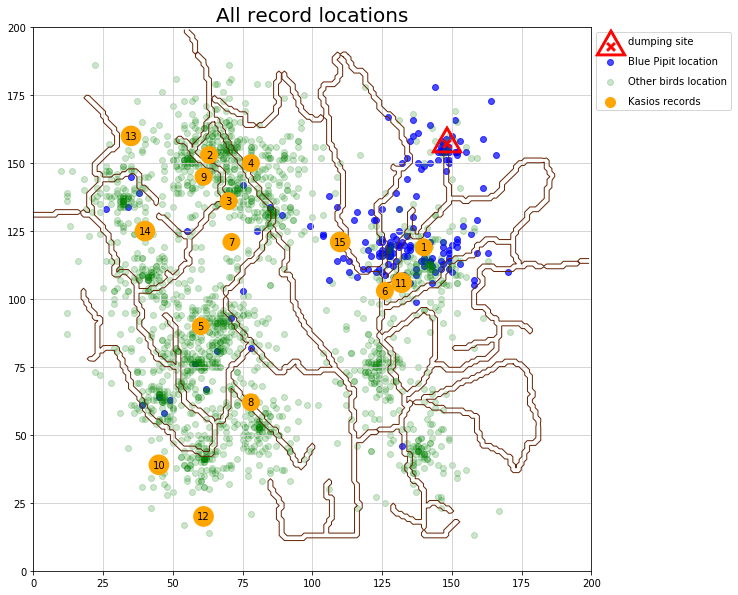

In [19]:
# PLot the map with all records and Kasios 
vst.plotmap(data, kasios_records, map_contour)

<div class="panel panel-primary">
      <div class="panel-heading">Remind: Main conclusions of the first assignment </div>
      <div class="panel-body">
<ul>    
    <li>We have enough records to keep only good quality and call&songs sounds. </li>
    <li>Blue Pipits nest or have nested IVO the dumping site </li>
    <li>We now have to check if Kasios records are Blue Pipit records, escpecially records #1, #11, #6 and #15</li>
    
</ul>    
    </div>
</div>

<div style="text-align: right"> <a href="#3" class="btn btn-primary">Open and read a sound file</a></div>

## Remove all non usefull data

In [20]:
# delete all useless data : keep only good quality, call and songs
data_sounds = data.loc[data['Quality'] <= 'C']
data_sounds = data_sounds.loc[data.Vocalization_type.isin(['song' , 'call','call, song'])]

In [21]:
print("We go from {} files to {} with better quality".format(len(data),len(data_sounds)))

We go from 2081 files to 1893 with better quality


In [22]:
cat_bird2 = pd.Categorical(data_sounds['English_name'],ordered=False)

<a id='2'></a>

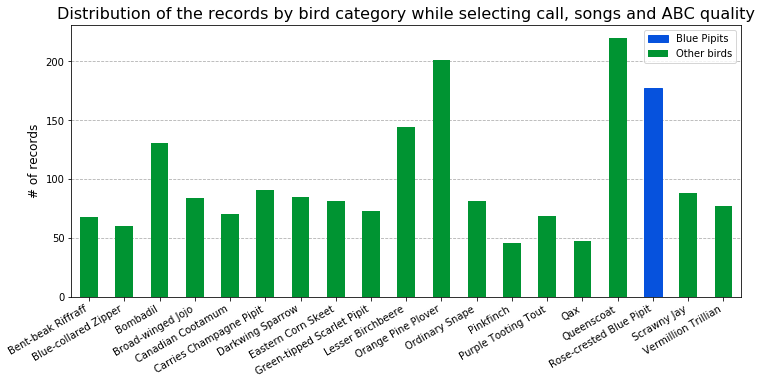

In [23]:
vst.plot_new_distribub(cat_bird2)

<div class="panel panel-primary">
      <div class="panel-heading">Comment</div>
      <div class="panel-body">We have enough samples to perform ML (1893 samples instead of 2084, more than 170 blue pipits)</div>
</div>

<div style="text-align: right"> <a href="#3" class="btn btn-primary">Open and read a sound file</a></div>

# Sounds file 

## Sounds file preprocessing

<a id='3'></a>

### Transform the mp3 into wav

In [24]:
#transform mp3 into wav
sound = AudioSegment.from_mp3("test.mp3")
sound = sound.set_frame_rate(44100)
sound = sound.set_channels(1)
sound.export("test.wav", format="wav")

<_io.BufferedRandom name='test.wav'>

In [25]:
# open the wav file 
rate, samples = wavfile.read("test.wav")

In [26]:
print(rate) ## nb frames per second

44100


<div class="panel panel-primary">
      <div class="panel-heading">Transform the mp3 into wav</div>
      <div class="panel-body">
<ul><li> Its easier working with wav file (uncompressed) 
</li><li>birds records have different frequency rate, depending of the source. We have to standardize the frequency rate (to 44100Hz, which is the most common one) 
</li><li>Similarly, birds records are stereo or mono. We will keep only one channel (stereo to mono)
</li></ul> </div></div>

<div style="text-align: right"> <a href="#4" class="btn btn-primary">First visualization</a></div>

In [27]:
print(samples.shape)

(5328000,)


In [28]:
n_samples = len(samples)

### From stereo to mono

In [29]:
# if stereo, keep only one channel
if samples.ndim == 2:
    samples = samples[:,0]

### Plot the whole sound file : magnitude and spectrogram

In [30]:
# get the frequencies, times and the spectrogram using our log_specgram function
freqs, times, spectrogram = vst.log_specgram(samples, rate)

<a id='4'></a>

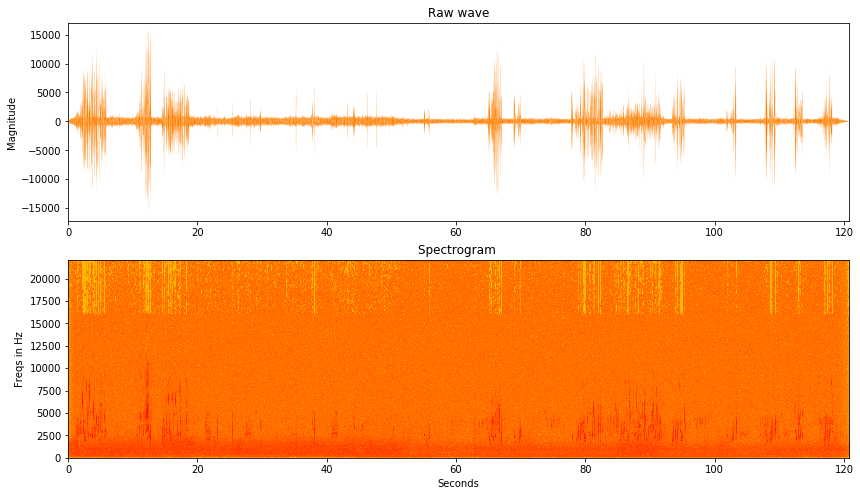

In [31]:
# plot the magnitude and the spectrogram on the scale time scale
vst.plot_magnitude_spectrogram(samples, rate, freqs, times, spectrogram)

<div class="panel panel-primary">
      <div class="panel-heading">First visualizations</div>
      <div class="panel-body">
    <ul><li> Need to normalize timely and powerly  
</li><li>Noises and silencies could be deleted (correspond to low magnitude / low freqeancies) 
</li><li>Its difficult to compare different records with this kind of graph
</li></ul> 
</div>
</div>

<div style="text-align: right"> <a href="#5" class="btn btn-primary">Another visualization</a></div>

### Visualize the FFT of the sound

In [32]:
# perform the fast fourier transform
fourier, power = vst.custom_fft(samples, rate)

<a id='5'></a>

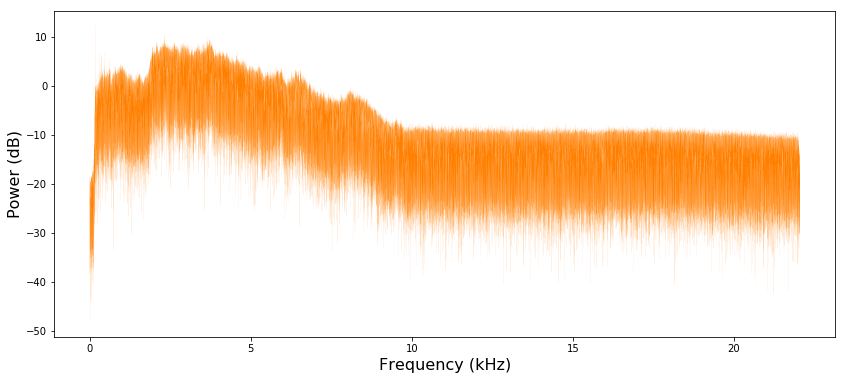

In [33]:
vst.plot_fft(fourier, power)

<div class="panel panel-primary">
      <div class="panel-heading">Fast Fourier Transform</div>
      <div class="panel-body"><ul><li>Advantage of this graph : do not depend of the lenght of the sound file. </li>
    <li>We have three dimensions to characterize the sound file : <strong>time, frequency and power</strong>.</li></ul></div>
</div>

<div style="text-align: right"> <a href="#6" class="btn btn-primary">Create feature</a></div>

## Create features step by step

Using the conclusions of T Papadopoulos, S.J. Roberts, K. Willis, _Automated bird sound recognition in realistic settings_, Sep.2018


<a id='6'></a>

### Step 1: select the most energetic frames

<div class="well">
"Namely, for each recording we identify the <strong>1% most energetic frames</strong> and we take the <strong>mean energy</strong> of those frames as an estimate of highest level for that particular recording. Following that, <strong>we select all frames of that recording that have power of at least 0.25</strong> of the estimated highest level as corresponding to bird sound and discard the remaining frames."
<br>    
T Papadopoulos, S.J. Roberts, K. Willis, <em>Automated bird sound recognition in realistic settings</em>, Sep.2018

</div>

<div style="text-align: right"> <a href="#7" class="btn btn-primary">Visualize result of step 1</a></div>

In [34]:
# mean of the 1% most energetic samples 
mean_high_NRJ_samples = np.mean(heapq.nlargest(n_samples//100, np.abs(samples)))
# select only samples of that recording that have power of at least 0.25 of the estimated highest level
samples = np.array([sample for i_sample, sample in enumerate(samples) if np.abs(sample) > 0.25 * mean_high_NRJ_samples])
# update nb frames
n_samples = len(samples)

In [35]:
freqs, times, spectrogram = vst.log_specgram(samples, rate)
fourier, power = vst.custom_fft(samples, rate)

<a id='7'></a>

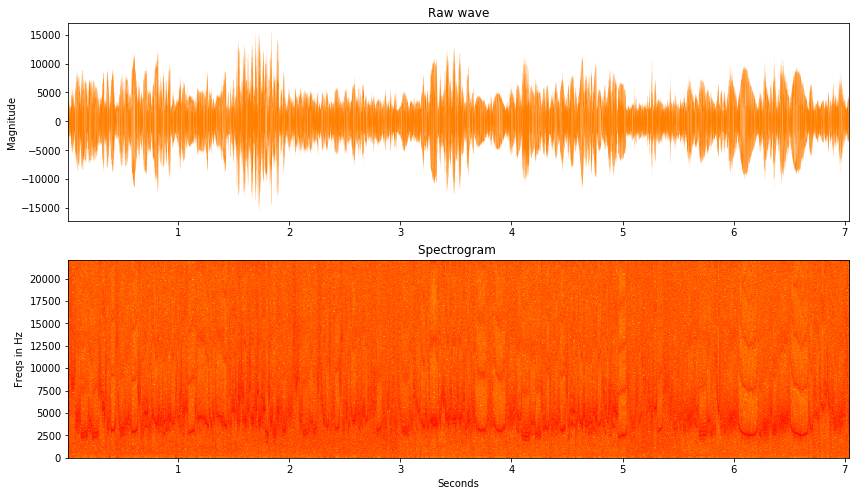

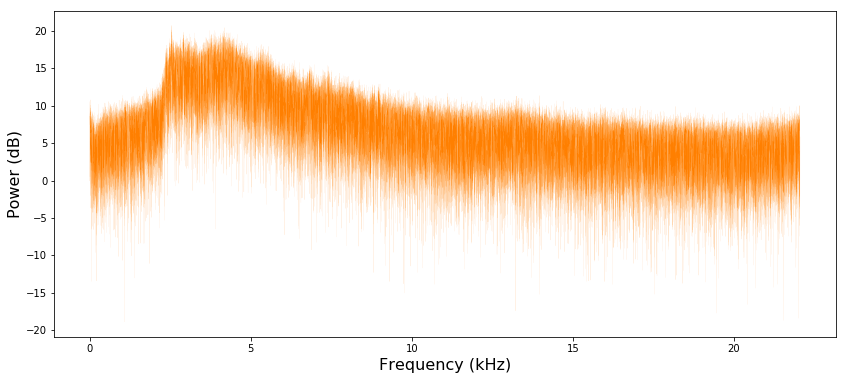

In [36]:
vst.plot_magnitude_spectrogram(samples, rate, freqs, times, spectrogram)
vst.plot_fft(fourier, power)

<div class="panel panel-primary">
      <div class="panel-heading">Create features step 1</div>
      <div class="panel-body">
<ul><li>This step allows removing some noise and all silencies. </li>
<li>Moreover, the lenght (and consequently the size of the file) is reduced from 120s to 7s...</li>
</ul></div></div>

<div style="text-align: right"> <a href="#8" class="btn btn-primary">Create feature next step</a></div>

<a id='8'></a>

### Step 2: split into 20ms frames

<div class="well">
"The features we extract are based on FFT-based spectrograms. The spectrogram of each of the training and test recording is computed with a <strong>frame length of 20ms, overlap of 50% </strong> and rectangular window."
    
<br>    
T Papadopoulos, S.J. Roberts, K. Willis, <em>Automated bird sound recognition in realistic settings</em>, Sep.2018

</div>

<div class="panel panel-primary">
      <div class="panel-heading">Create features step 2</div>
      <div class="panel-body">
<ul><li>The overlapping keep the time component</li>
<li>Already done with the function log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10)</li>
</ul></div></div>

<div style="text-align: right"> <a href="#9" class="btn btn-primary">Create Features Next step</a></div>

Already done with the function log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10)

In [37]:
window_size=20
step_size=10

<a id='9'></a>

### Step 3: Keep only 1-10KHz

<div class="well">
"In order to minimize the contribution of low frequency wind noise in the recordings, <strong>only the bins corresponding to frequencies between 1kHz and 10kHz are kept</strong>. Those frequency limits are within the range of what is typically used in existing bird recognition studies and slight changes around these values should not be expected to have a
considerable effect on the system’s performance "
    
<br>    
T Papadopoulos, S.J. Roberts, K. Willis, <em>Automated bird sound recognition in realistic settings</em>, Sep.2018

</div>

<div class="panel panel-primary">
      <div class="panel-heading">Create features step 3</div>
      <div class="panel-body">
<ul><li>According to specialists, many bird songs have frequency ranges between 1 and 8 kHz, with maximum sensitivity between 1 and 5 kHz. This cut is logical</li>
</ul></div></div>

<div style="text-align: right"> <a href="#11" class="btn btn-primary">Create feature next step</a></div>

In [38]:
# keep only fq between 1kHz and 10 kHz
indices = [i for i, fq in enumerate(freqs) if fq>1000 and fq<10000]
freqs_red = freqs[indices]
spectrogram_red = spectrogram[:,indices]

<a id='11'></a>

### Step 4: normalize

<div class="well">
" Four types of frame-level features were considered, all choices from the various types described in Briggs et al.(2009) and Stowell & Plumbley (2014a). More specifically, after <strong>normalising the absolute value of each frame’s spectrum to sum unity</strong>, we computed ..."
    
<br>    
T Papadopoulos, S.J. Roberts, K. Willis, <em>Automated bird sound recognition in realistic settings</em>, Sep.2018

</div>

<div style="text-align: right"> <a href="#12" class="btn btn-primary">Visualize the result</a></div>

In [39]:
from sklearn.preprocessing import normalize

In [40]:
sequence_spectogram_normalized = normalize(spectrogram_red, norm="l1", axis=1)

<a id='12'></a>

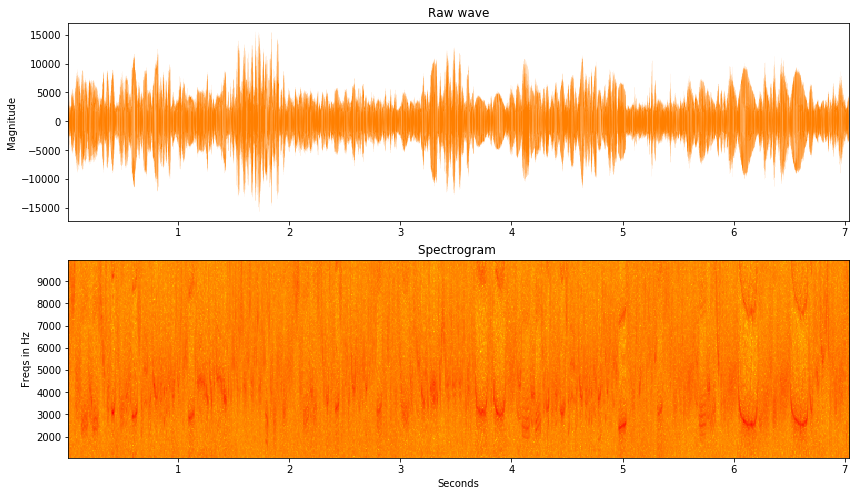

In [41]:
vst.plot_magnitude_spectrogram(samples, rate, freqs_red, times, sequence_spectogram_normalized)

<div class="panel panel-primary">
      <div class="panel-heading">Create features step 4</div>
      <div class="panel-body">
<ul><li>NSTR</li>
</ul></div></div>

<div style="text-align: right"> <a href="#13" class="btn btn-primary">Create Features next step</a></div>

<a id='13'></a>

### Step 5: Concatene and compute sequence of 100 frames

<div class="well">
"the individual sequences of frame-level features
from each <strong>recording of the same species are lined-up in one sequence</strong> (which
preserves the original frame sequence in each audio recording but contains ‘cuts’
due to rejected frames and due to the line-up of the different recordings) and
<strong>sequences of features obtained from 100 frames</strong> are taken."
<br>    
T Papadopoulos, S.J. Roberts, K. Willis, <em>Automated bird sound recognition in realistic settings</em>, Sep.2018

</div>

<div class="panel panel-primary">
      <div class="panel-heading">Create features step 5</div>
      <div class="panel-body">
<ul><li>The concatenation off all records by specy allows not to lost too many data </li>
<li>All sequences will have an uniformed lenght of 2s (100 frames of 20ms)</li>
</ul></div></div>

<div style="text-align: right"> <a href="#14" class="btn btn-primary">Visualize the result</a></div>

In [42]:
# Lets split the spectrogram into sequences
list_sequences = vst.get_sequences(sequence_spectogram_normalized)

In [43]:
# let get the first sequence.
sequence_spectogram_normalized = list_sequences[0]

<a id='14'></a>

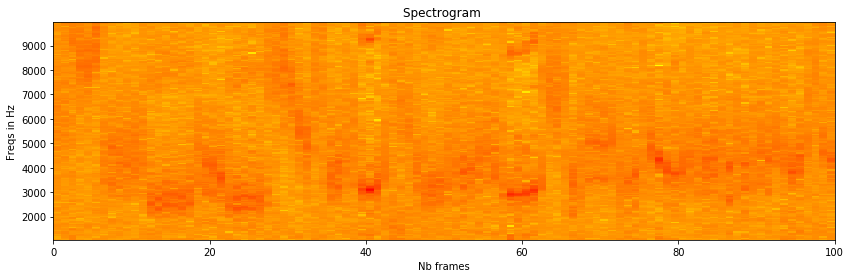

In [44]:
vst.plot_spectrogram(freqs_red, times, sequence_spectogram_normalized)

<div class="panel panel-primary">
      <div class="panel-heading">Create features step 5/2</div>
      <div class="panel-body">
<ul><li>All sequences have the same number of frames (100), the same number of frequency bins (from 1 to 10 KHz) and a normalized magnitude.</li><li>This sequence is now standardized, and represent a good baseline.</li>
</ul></div></div>

<div style="text-align: right"> <a href="#15" class="btn btn-primary">Create feature next step</a></div>

<a id='15'></a>

### Step 6: create features

<div class="well">
" Four types of frame-level features were considered, all choices from the various types described in Briggs et al.(2009) and Stowell & Plumbley (2014a). More specifically, after <strong>normalising the absolute value of each frame’s spectrum to sum unity</strong>, we computed the mean (denoted here as f mean ), standard deviation (f std ), mode (f mode ) and the difference between the mode of each selected frame and its successor in the original recording [...]
     We consider three types of binned histograms: 
<ul class="list">
  <li class="list-item">
two-dimensional histograms of the f_mean and f_std frame-level features with 100 and 50 bins spaced uniformly from 1kHz to 10kHz along the two respective dimensions (corresponding to 5000-dimensional feature vectors)  
</li>
 <li class="list-item">
one-dimensional histograms of the f_mode feature with 100 bins spaced uniformly from 1kHz to 10kHz along the f mode dimension (corresponding to 100-dimensional feature vectors)
</li> 
<li class="list-item">
two-
dimensional histograms of the f_mode and Δf mode pair of features with 100 bins
spaced uniformly from 1kHz to 10kHz along the f mode dimension and 50 bins
spaced uniformly from -2kHz to 2kHz along the Δf mode dimension (corresponding
to 5000-dimensional feature vectors)."
</li>
</ul> 
T Papadopoulos, S.J. Roberts, K. Willis, <em>Automated bird sound recognition in realistic settings</em>, Sep.2018

</div>


<div class="panel panel-primary">
      <div class="panel-heading">Mathematical interpretation</div>
      <div class="panel-body">
$$ f_{mean}(i) = \int \text{spec}(f_i).f_i .\partial f_i$$
$$ f_{std}(i) = \sqrt{\int \text{spec}(f_i) (f_i - f_{mean})^2\partial f_i}$$
$$ f_{mode}(i) = f_i(F)\text{ , with F} = \arg\max \text{spec}(f_i)$$
$$ f_{\Delta mode}(i) = f_{mode} (i) - f_{mode} (i-1)$$

<ul><li>All are vector of size 100 (nb frames)</li>
<li>$\Delta mode$ allows keeping time aspect</li>
<li>We restricted $f_{std}$ beetween 1 and 4KHz (no higher value) </li>
    <li> Total 10100 features </li>
</ul>

</div></div>



<div style="text-align: right"> <a href="#16" class="btn btn-primary">Visualize features</a></div>

In [45]:
# Create edges for the histograms from e_min to e_max
f_mean_edges = vst.edges(1000, 10000, 100)
f_std_edges = vst.edges(1000, 4000, 50)
f_mode_edges = vst.edges(1000, 10000, 100)
f_delta_mode_edges = vst.edges(-2000, 2000, 50)

In [46]:
n_frames_sequence = min(sequence_spectogram_normalized.shape[0], 100)

In [47]:
# calculate mean, std, mode and delta_mode
f_mean = [np.sum(freqs_red * sequence_spectogram_normalized[i]) 
          for i in range(n_frames_sequence)]
f_std = [(np.abs(np.sum(sequence_spectogram_normalized[i] 
                        * ((freqs_red - f_mean[i]) ** 2) ))) ** (0.5) 
         for i in range(n_frames_sequence)]
f_mode = [freqs_red[np.argmax(sequence_spectogram_normalized[i])] 
          for i in range(n_frames_sequence)]
f_delta_mode = np.roll(f_mode, -1) - f_mode

In [48]:
# create histogramms
sequence_histogram1, f_mean_edges, f_std_edges = np.histogram2d(f_mean, f_std, bins=(f_mean_edges, f_std_edges))
sequence_histogram2, f_mode_edges = np.histogram(f_mode, bins=f_mode_edges)
sequence_histogram3, f_mode_edges, f_delta_mode_edges = np.histogram2d(f_mode, f_delta_mode, bins=(f_mode_edges, f_delta_mode_edges))

<a id='16'></a>

In [49]:
features1 = sequence_histogram1.flatten()
features2 = sequence_histogram2
features3 = sequence_histogram3.flatten()

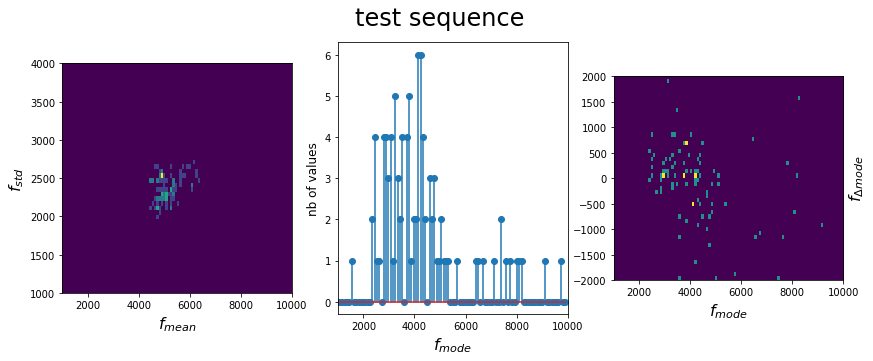

In [50]:
# Plot the 3 histogram = our features for this sequence
vst.plot2_features("test sequence", sequence_histogram1, sequence_histogram2, 
                   sequence_histogram3,  freqs_red)

<div class="panel panel-primary">
      <div class="panel-heading">Features</div>
      <div class="panel-body">
<ul><li>We now have to try applying these transformations to all birds records, and check if these features are sufficient to compare species.</li>
</ul></div></div>

<div style="text-align: right"> <a href="#17" class="btn btn-primary">Visualize the mean for each specy</a></div>

## Scalability

<div class="panel panel-primary">
      <div class="panel-heading">Scalability: apply these steps to all concerned mp3 files to create our dataset</div>
      <div class="panel-body">
<ul><li>To avoid having to create all features at each time, we stored all datas in csv files</li>
<li>We put the lines of command as comment (markdown), and just read our csv files.</li>
</ul></div></div>

### Create wav from mp3

Transform all mp3 from the In folder that correspond to a good record into wav to Out folder with a rate of 44100 Hz

```python
# transform all mp3 into wav
f = IntProgress(min=0, max=len(data), description='Load files:', bar_style='success') # instantiate the bar
print("progress")
display(f) # display the bar
for file in os.listdir("Sounds/In/"):
    
    record_id = int(max(re.findall('\d+', file), key=len))
    # if the ID is in data_sounds, we apply 
    if record_id in data_sounds['File ID'].values:
        sound = AudioSegment.from_mp3("Sounds/In/"+file)
        sound = sound.set_frame_rate(44100)
        sound = sound.set_channels(1)
        sound.export("Sounds/Out/" + str(record_id) + ".wav", format="wav")
    f.value += 1
print("done !")
```

### Create features

```python
# create all spectrogramms using parallellizing 
cores = multiprocessing.cpu_count()
pool = Pool(processes=cores)
file_list = list(os.listdir("Sounds/Out/"))

all_spectrograms = [[] for _ in range(nb_categories)]

for category, spectrogram, freqs_red in tqdm(pool.imap_unordered(get_spectrogram, file_list), total=len(file_list)):
    all_spectrograms[category].append(spectrogram)
```

```python
# retrieve sequences from spectrograms
all_sequences = get_sequences_per_category(all_spectrograms)
```

```python
# create the dataset from the sequences
dataset = pd.DataFrame(columns=range(10101))
n_rows = 0
for category in range(nb_categories):
    for j, sequence in enumerate(all_sequences[category]):
        dataset.loc[n_rows] = get_features(category, sequence, freqs_red)
        n_rows += 1
        
```       


```python
# create the dataset
dataset.to_csv("dataset.csv", float_format='%.3f')
```

```python
dataset2 = dataset.copy()

dataset2 = dataset2.astype(int)

dataset2.to_csv("dataset2.csv")

len(dataset)
```

Instead of executing previous lines of commands, just load the dataset.

In [51]:
dataset = pd.read_csv("dataset2.csv")

In [52]:
dataset = dataset.drop(dataset.columns[0], axis=1)  

# Compare differents species

<div class="panel panel-primary">
      <div class="panel-heading">Compare the species</div>
      <div class="panel-body">
<ul><li>We computed the averaged feature by specy for all records</li>
</ul></div></div>

In [53]:
dataset_category = dataset.groupby(['0']).mean()
dataset_category.insert(0, '0', 0.0)

In [54]:
categories  = []
features1 = []
features2 = []
features3 = []
for row in dataset_category.iterrows():
    index, data_i = row
    categories.append(index)
    features1.append(np.reshape(data_i.values[0:5000], (50, 100)).T)
    features2.append(data_i.values[5000:5100])
    features3.append(np.reshape(data_i.values[5100:10100], (50, 100)).T)
freqs = np.array(range(1050, 10000, 50))

## Plot the features

<a id='17'></a>

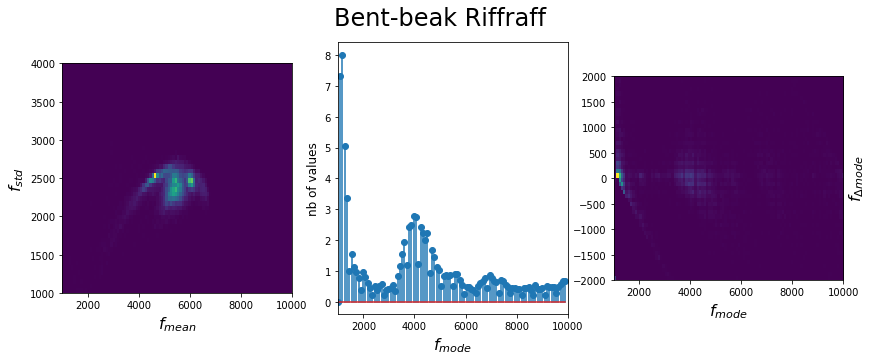

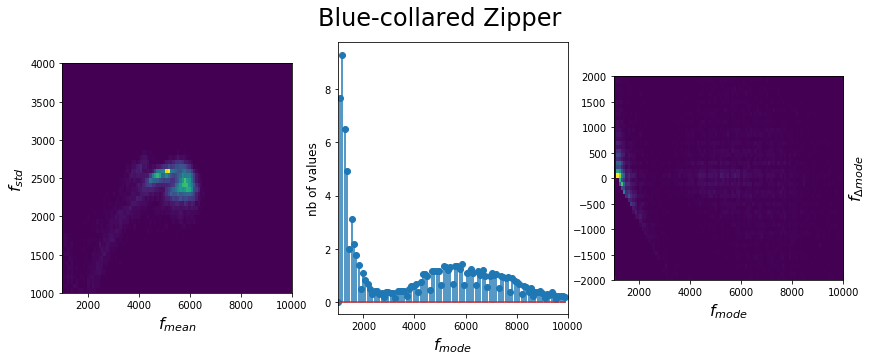

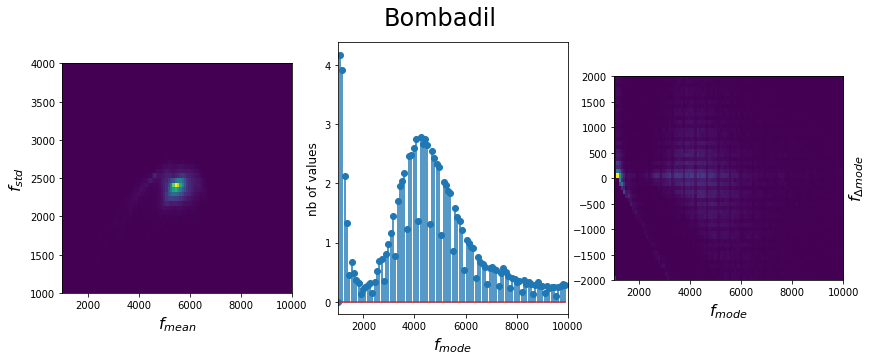

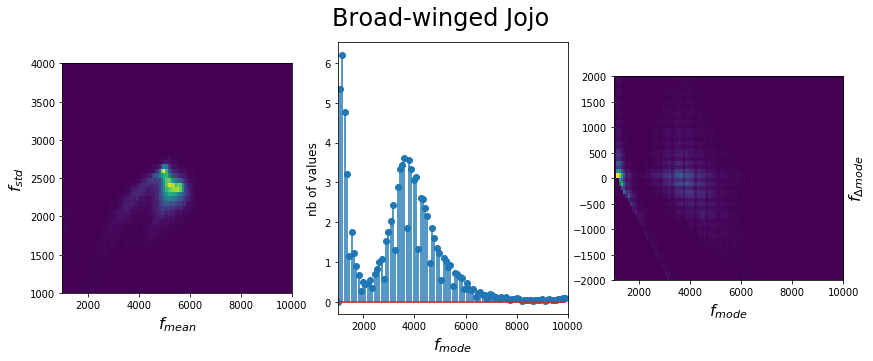

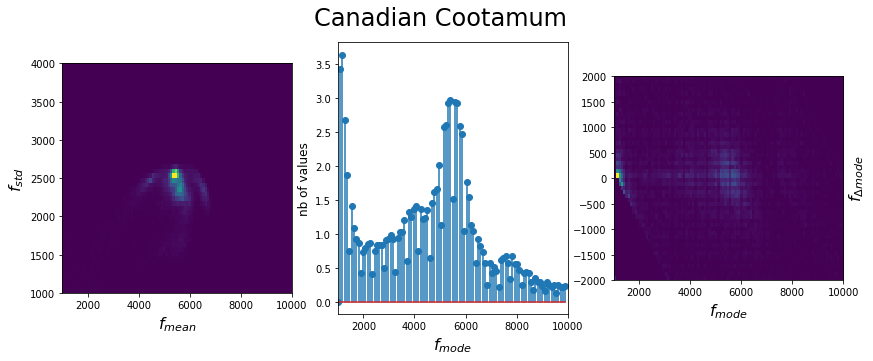

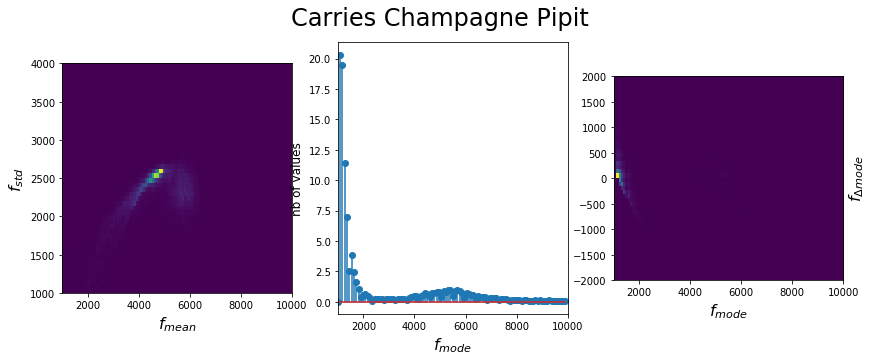

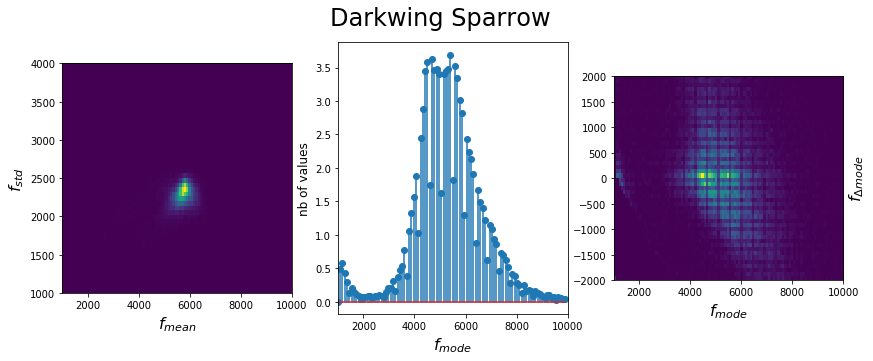

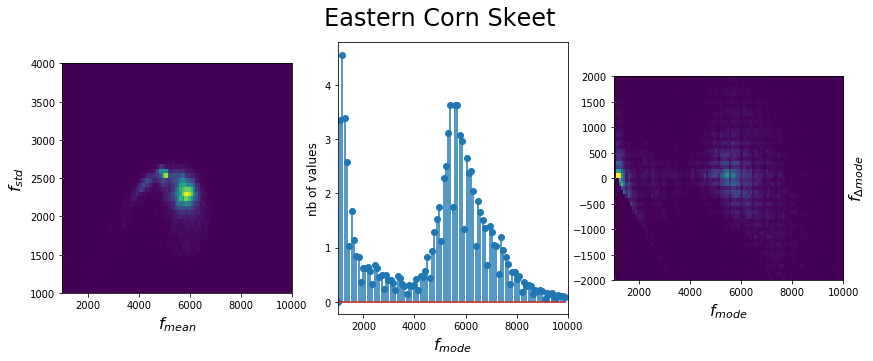

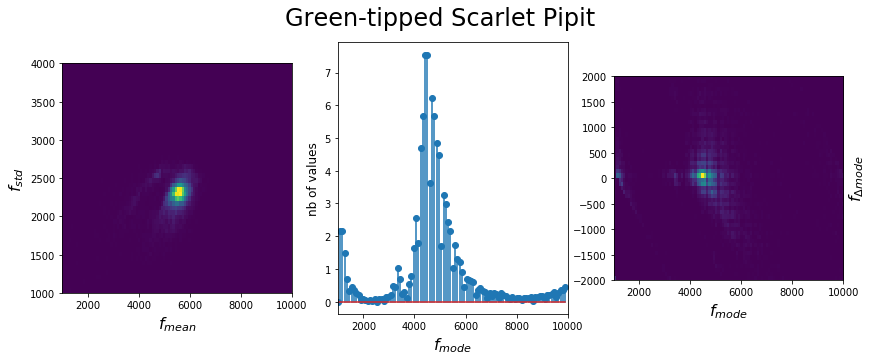

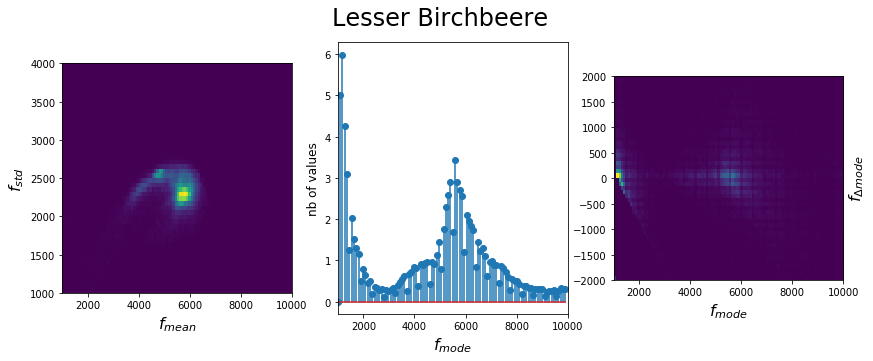

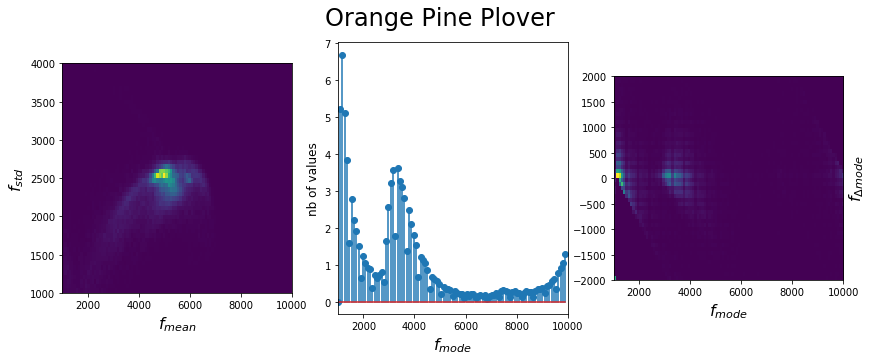

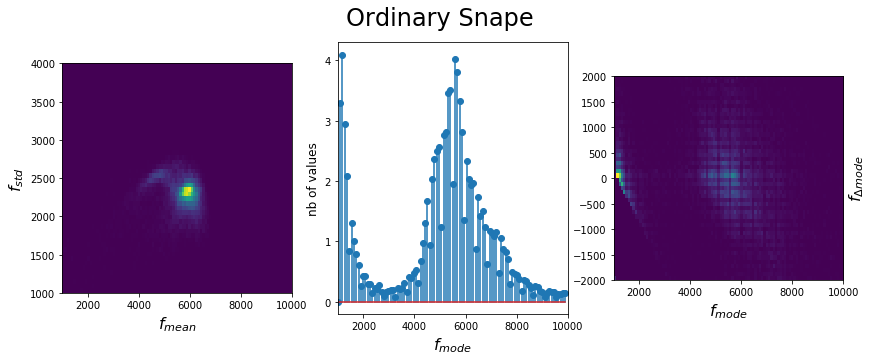

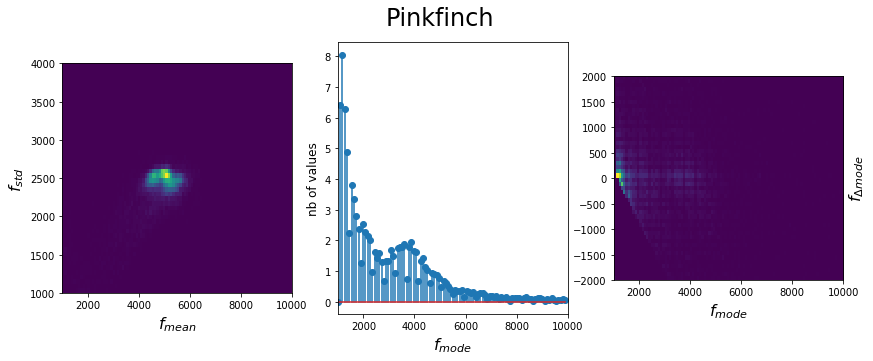

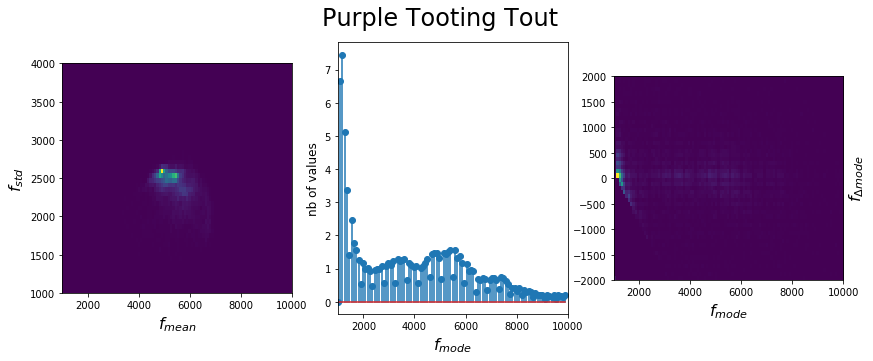

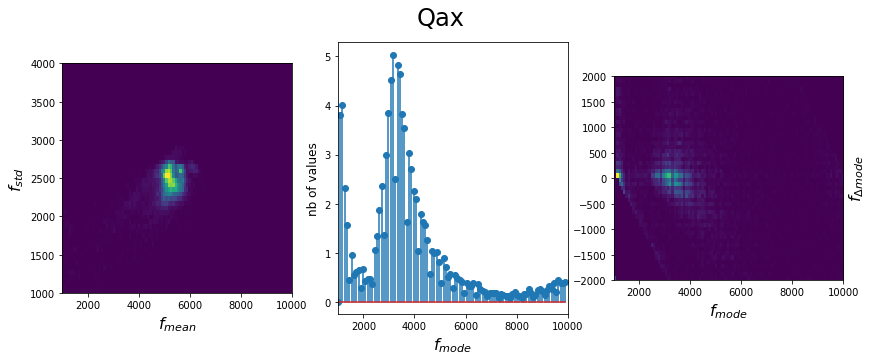

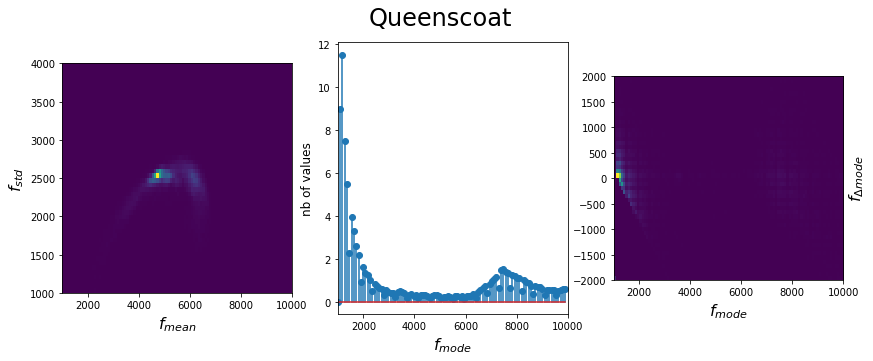

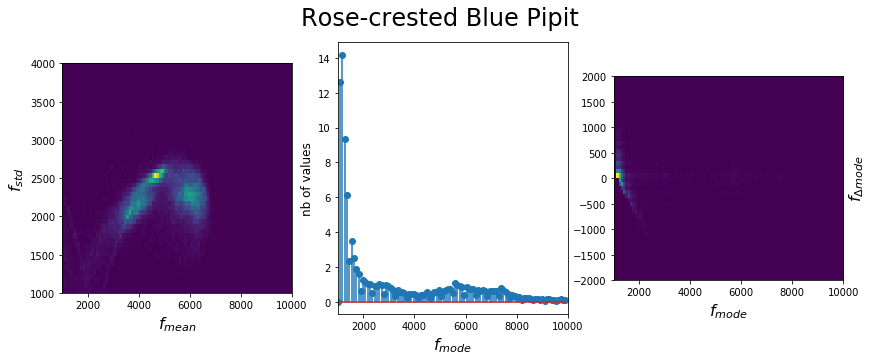

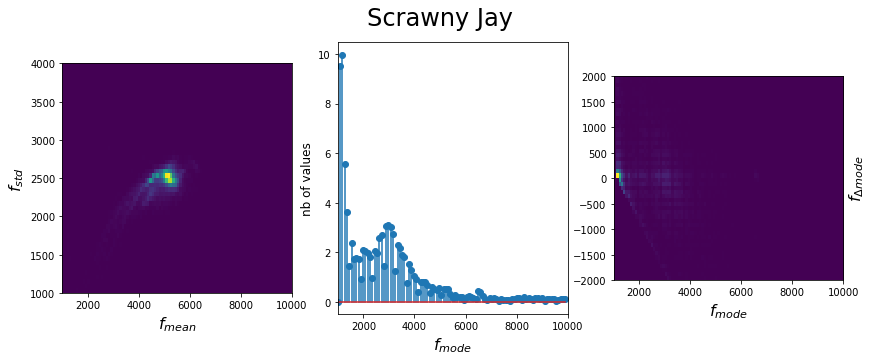

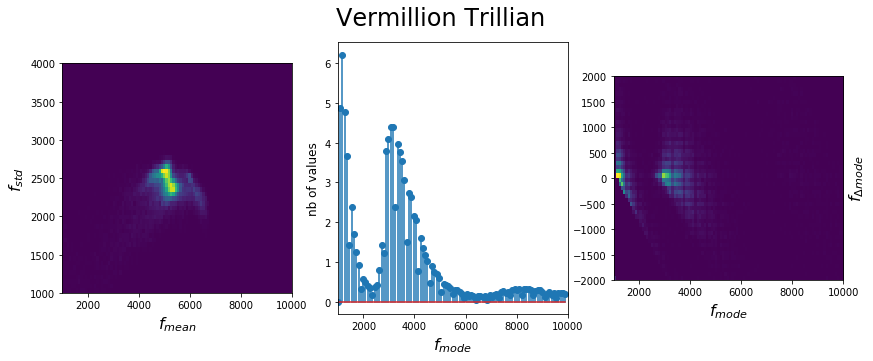

In [55]:
for i, H1, H2, H3 in zip(categories, features1, features2, features3):
    vst.plot2_features(cat_bird.categories.tolist()[i], H1, H2, H3, freqs)

<div class="panel panel-primary">
      <div class="panel-heading">Comparison of species</div>
      <div class="panel-body">
<ul><li>We observe differences beetween species</li>
<li>The three histograms are usefull to discriminate birds.</li>
<li>Lets try 'automatic' comparisons with similarity measure</li>
</ul></div></div>

<div style="text-align: right"> <a href="#18" class="btn btn-primary">Test a similarity measure</a></div>

## Similarity

In [56]:
# using the ssim (measure to compare images)
from skimage.measure import compare_ssim

In [108]:
# just calculate the mean... of the three ssim
ssim_beetween = np.array([[np.mean([compare_ssim(features1[i], features1[j], full=True)[0], 
                                    compare_ssim(features2[i], features2[j], full=True)[0],
                                    compare_ssim(features3[i], features3[j], full=True)[0]])
                           for i in range(nb_categories)] 
                          for j in range(nb_categories)])

D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\skimage\util\arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


<a id='18'></a>

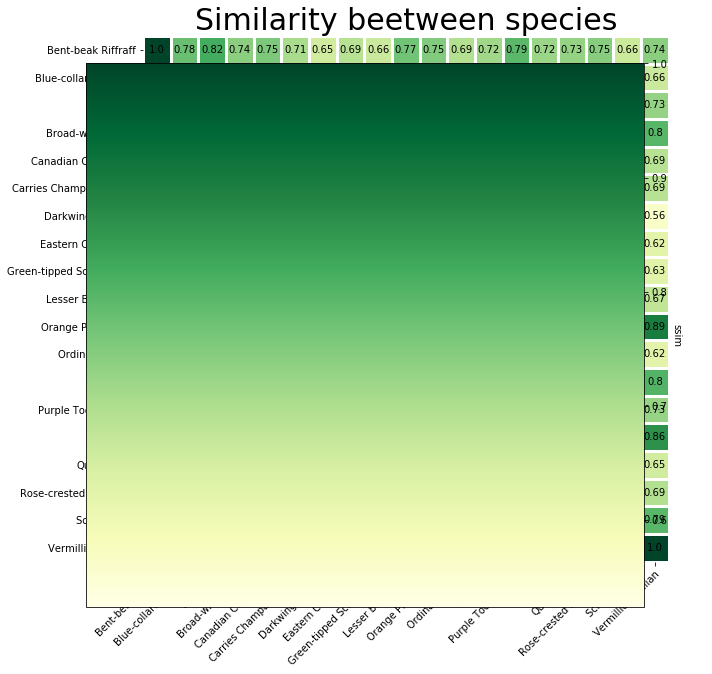

In [112]:
vst.plot_heatmap(ssim_beetween, cat_bird.categories.tolist(), 
                 cat_bird.categories.tolist(), "Similarity beetween species", 
                 cmap="YlGn", cbarlabel="ssim", txt=True)

<div class="panel panel-primary">
      <div class="panel-heading">Heatmap similarities</div>
      <div class="panel-body">
<ul><li>This kind of graphic allows to compare more easely differents sounds</li>
<li>Lets try transform it into a weighted graph (cf lecture on networks)</li>
</ul></div></div>

<div style="text-align: right"> <a href="#19" class="btn btn-primary">Graph</a></div>

## Graph of similarities

In [59]:
import networkx as nx
from networkx.readwrite import json_graph
import json
from IPython.display import display, HTML, Javascript

In [60]:
labels = {}
for i, cat in enumerate(cat_bird.categories.tolist()):
    labels[i]=cat

In [61]:
def create_graph(similarity, threshold):
    n = similarity.shape[0]
    G = nx.Graph()
    G.add_nodes_from([i for i in range(n)])
    for i in range(n):
        for j in range(i+1, n):
            if similarity[i,j]> threshold:
                G.add_edge(i, j, weight=( similarity[i,j] - threshold) * 100 ) 
    return G

In [62]:
G = create_graph(ssim_beetween, 0.75)

for ix in G.nodes():
    G.node[ix]['category'] = labels[ix]
    G.node[ix]['isKasios'] = 0

for ix,deg in G.degree():
    G.node[ix]['degree'] = deg
    G.node[ix]['parity'] = (1-deg%2)
    #G.node[ix]['katz'] = 0.1
for ix,katz in nx.katz_centrality(G).items():
    G.node[ix]['katz'] = katz

In [63]:
# create a json file
datajson = json_graph.node_link_data(G)
with open('graphsim.json', 'w') as f:
    json.dump(datajson, f, indent=4)

<a id='19'></a>

In [64]:
# interactive graph ; the edge width depends of the similarity beetween species
display(HTML(vst.js_getResults))

<div class="panel panel-primary">
      <div class="panel-heading">Graph of similarities</div>
      <div class="panel-body">
<ul><li>We now have to add Kasios birds... and perfom the classification</li>
</ul></div></div>

<div style="text-align: right"> <a href="#20" class="btn btn-primary">Kasios records visualization</a></div>

# Classification

## Kasios records

```python
f = IntProgress(min=0, max=15, description='Load files:', bar_style='success') # instantiate the bar
display(f) # display the bar
for file in os.listdir("Sounds_Kasios/In/"):
    
    record_id = int(max(re.findall('\d+', file), key=len))
    # if the ID is in data_sounds, we apply 
    sound = AudioSegment.from_mp3("Sounds_Kasios/In/"+file)
    sound = sound.set_frame_rate(44100)
    sound = sound.set_channels(1)
    sound.export("Sounds_Kasios/Out/" + str(record_id) + ".wav", format="wav")
    f.value += 1
nb_kasios = f.value
```

```python
list_kasios_sequences = [[] for i in range(nb_kasios)]
for i in range(nb_kasios):
    t_spectogram_normalized, t_freqs_red = get_spectrogram_kasios(i+1)
    list_kasios_sequences[i].extend(get_sequences(t_spectogram_normalized))


# create the dataset from the sequences
dataset_kasios = pd.DataFrame(columns=range(10101))
n_rows = 0
for id in range(nb_kasios):
    for _, sequence in enumerate(list_kasios_sequences[id]):
        dataset_kasios.loc[n_rows] = get_features(id, sequence, t_freqs_red)
        n_rows += 1
```

```python
dataset_kasios.to_csv("dataset_kasios.csv", float_format='%.3f')
```

In [65]:
dataset_kasios = pd.read_csv("dataset_kasios.csv")

In [66]:
dataset_kasios = dataset_kasios.drop(dataset_kasios.columns[0], axis=1)  

In [67]:
kasios_mean = dataset_kasios.groupby(['0']).mean()

In [68]:
kasios_mean.insert(0, '0', 0.0)

In [69]:
l_kasios_id  = []
features1k = []
features2k = []
features3k = []
for row in kasios_mean.iterrows():
    index, data_i = row
    l_kasios_id.append(index)
    features1k.append(np.reshape(data_i.values[0:5000], (50, 100)).T)
    features2k.append(data_i.values[5000:5100])
    features3k.append(np.reshape(data_i.values[5100:10100], (50, 100)).T)
freqs = np.array(range(1050, 10000, 50))

<a id='20'></a>

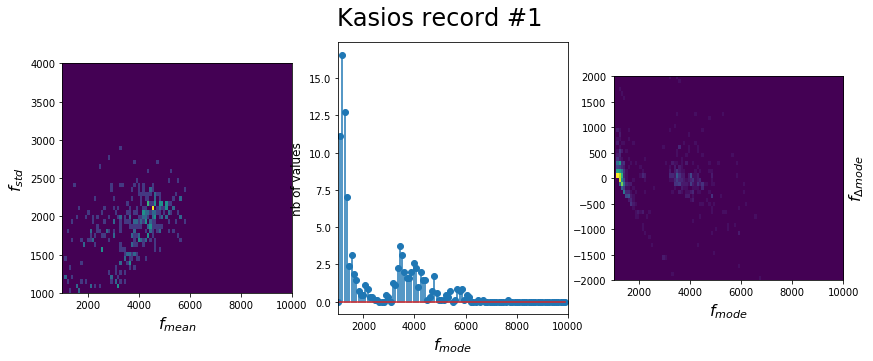

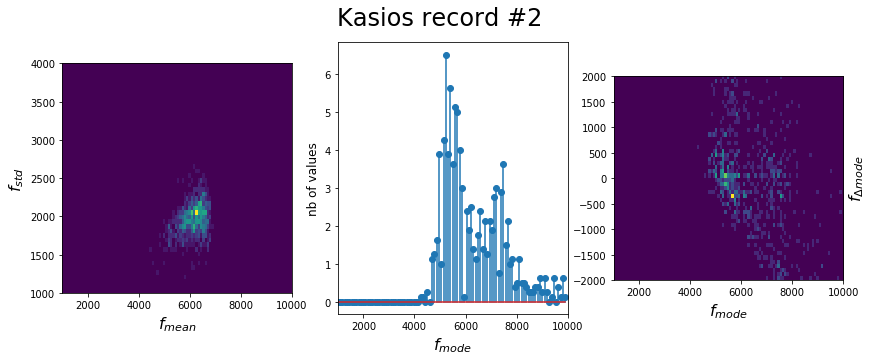

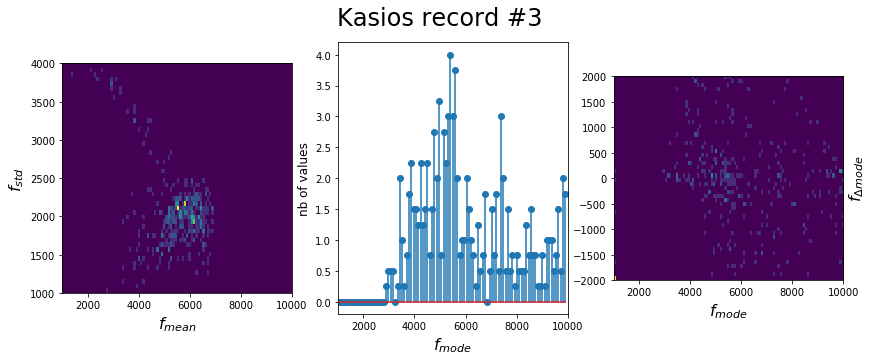

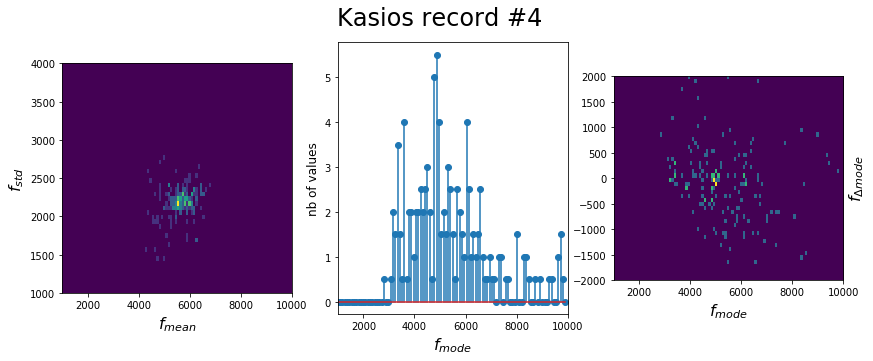

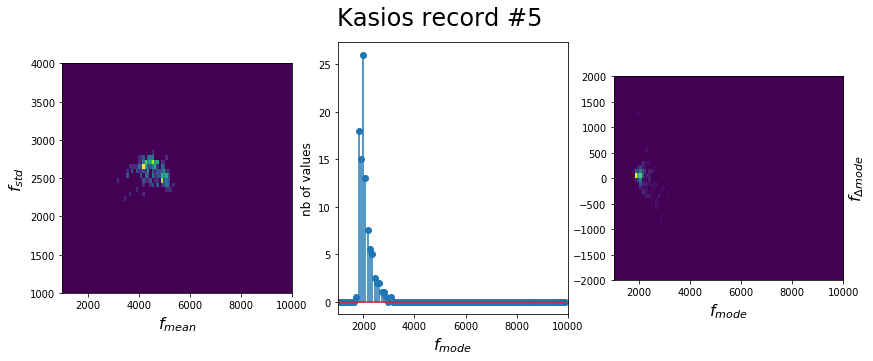

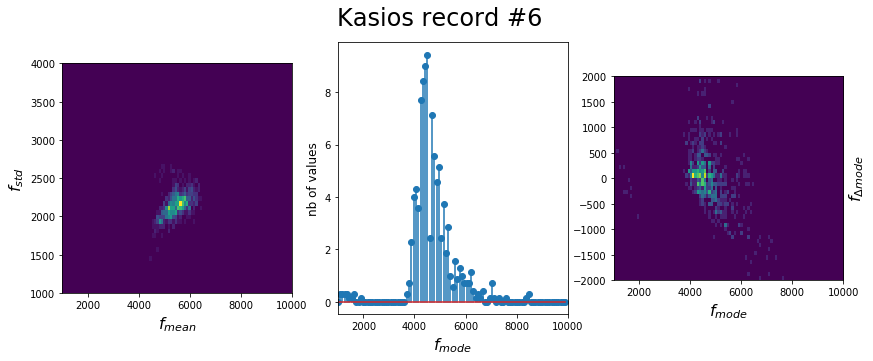

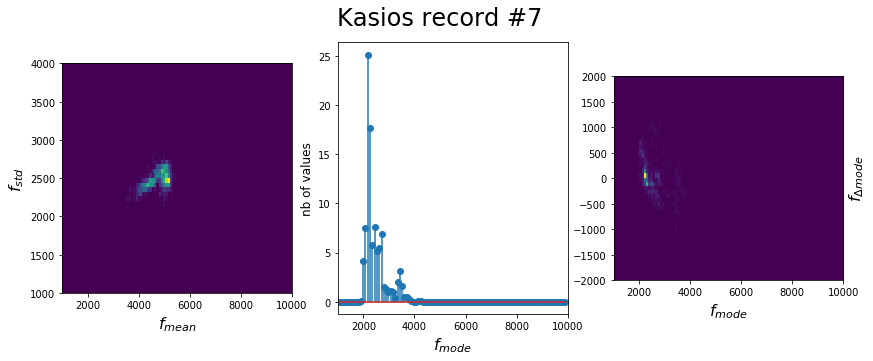

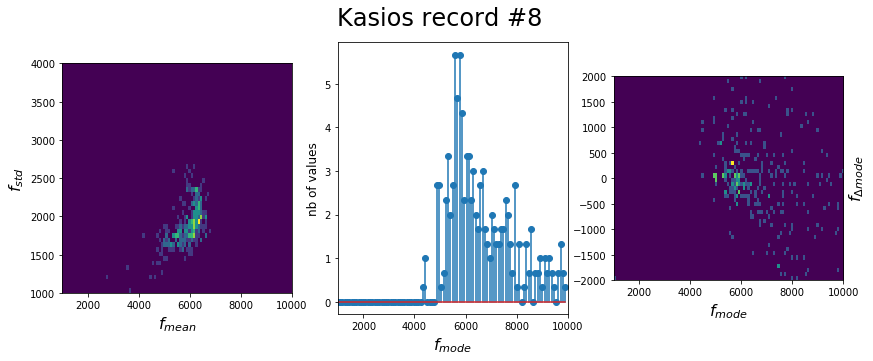

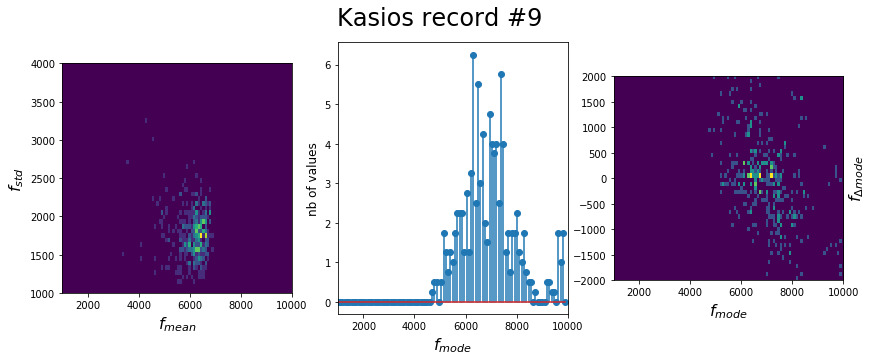

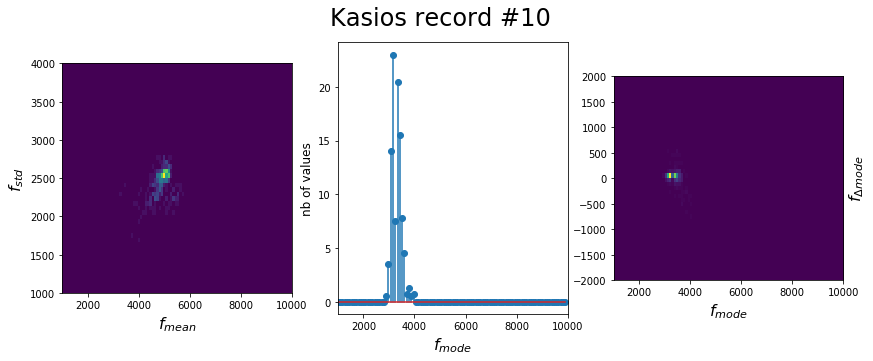

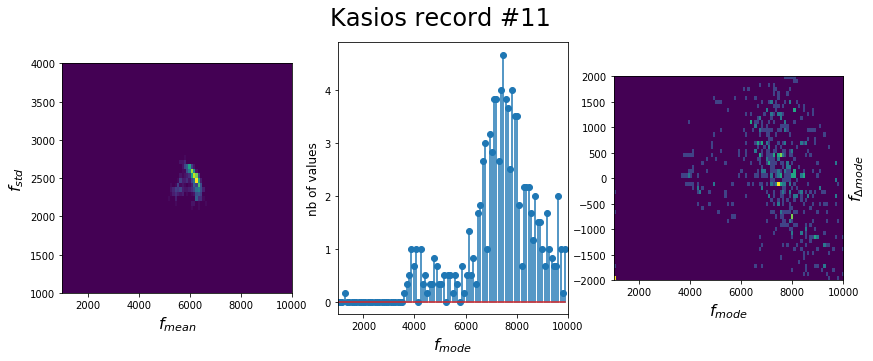

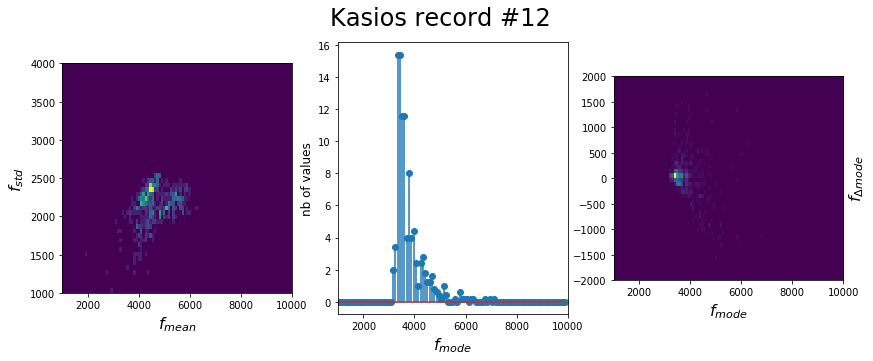

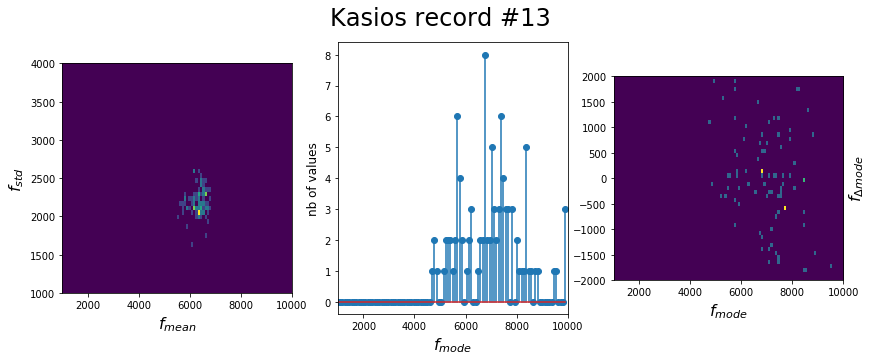

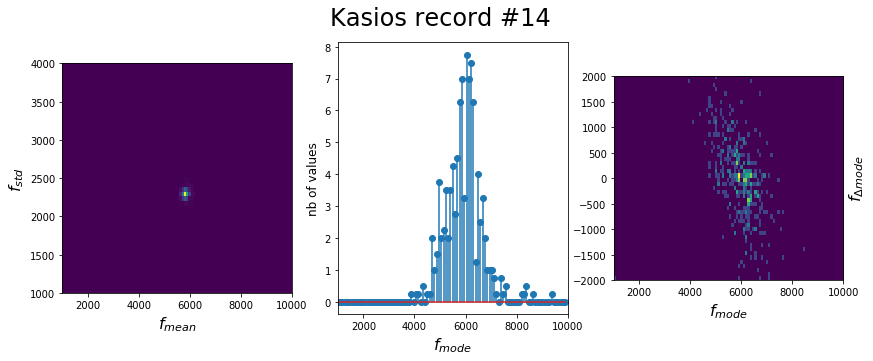

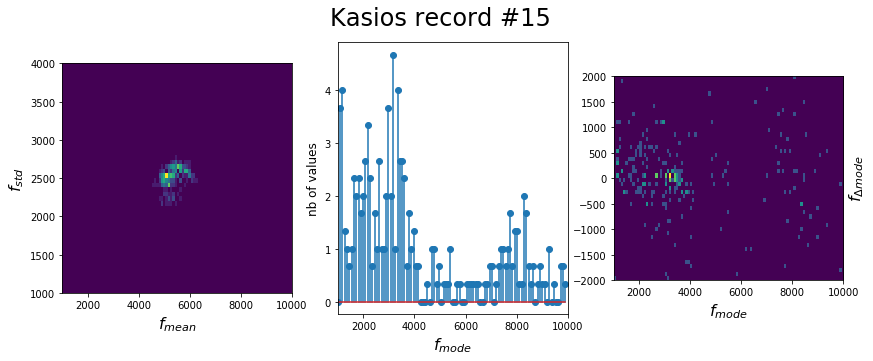

In [70]:
for i, H1, H2, H3 in zip(l_kasios_id, features1k, features2k, features3k):
    vst.plot2_features("Kasios record #" + str(int(i+1)), H1, H2, H3, freqs)

<div style="text-align: right"> <a href="#21" class="btn btn-primary">Classification</a></div>

In [71]:
nb_kasios = len(l_kasios_id)

In [72]:
kasios_label = ["Kasios record #" + str(int(i+1)) for i in range(nb_kasios)]

In [73]:
# test of ssim beetween kasios and species
ssim_k = np.array([[np.mean([compare_ssim(features1[i], features1k[j], full=True)[0], 
                             compare_ssim(features2[i], features2k[j], full=True)[0],
                             compare_ssim(features3[i], features3k[j], full=True)[0]])
                           for i in range(nb_categories)] 
                          for j in range(nb_kasios)])

D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\skimage\util\arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


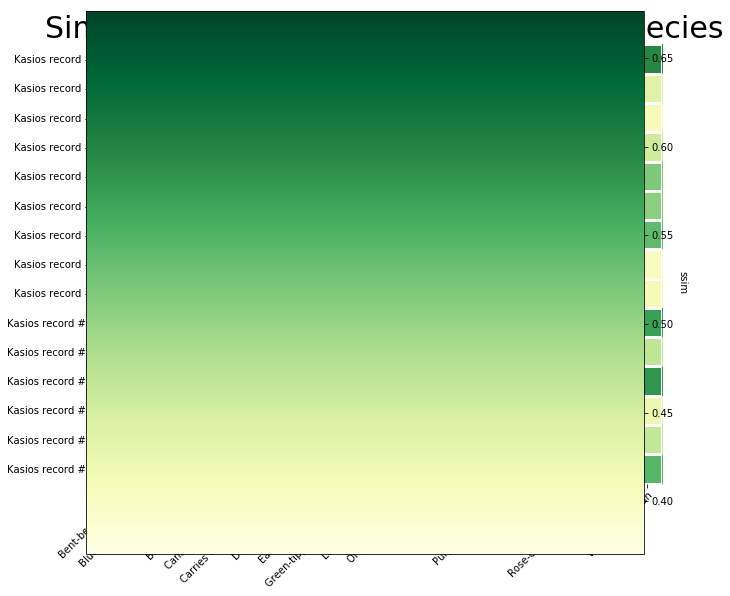

In [74]:
vst.plot_heatmap(ssim_k, kasios_label, cat_bird.categories.tolist(), 
                 "Similarity beetween Kasios birds and species", 
                 cmap="YlGn", cbarlabel="ssim")

## Multi-class Classification

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [76]:
# dataset with all 10100 fatures
dataset3 = dataset.copy()
y = dataset3['0']
X = dataset3.drop(dataset3.columns[0], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [77]:
# standardization of all features
scaler1 = StandardScaler()
scaler1.fit(X_train)
X_train = scaler1.transform(X_train)
X_test = scaler1.transform(X_test)
kasios_id = dataset_kasios['0']
X_kasios = dataset_kasios.drop(dataset_kasios.columns[0], axis=1)
X_kasios = scaler1.transform(X_kasios)

D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """


In [78]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

<a id='21'></a>

In [79]:
random_forest = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=1))
random_forest.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
          n_jobs=None)

In [80]:
random_forest.score(X_test, y_test)

0.5107142857142857

<div class="panel panel-primary">
      <div class="panel-heading">Classification multiclass</div>
      <div class="panel-body">
<ul><li>0.51 in 19-multiclass is not especially a poor result.</li>
<li>Random_forest is the better classifier we tried</li>
</ul></div></div>

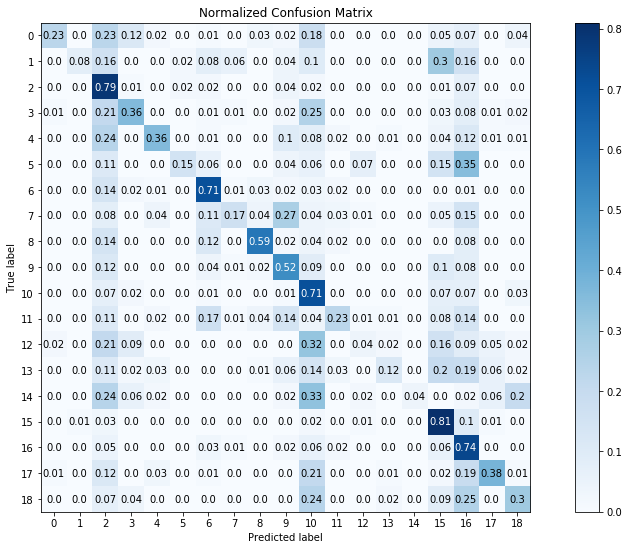

In [84]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, random_forest.predict(X_test), normalize=True, figsize=(16,9))

In [85]:
probas = random_forest.predict_proba(X_kasios)

In [86]:
# transform into an array by kasios record // aggregate by mean
i = 0
probas_kasios = []
for j in range(nb_kasios):
    probas_kasios.append(np.mean(np.array([probas[i+k] for k in range(kasios_id.value_counts()[j])]), axis=0))
    i+=kasios_id.value_counts()[j]
probas_kasios = np.array(probas_kasios)

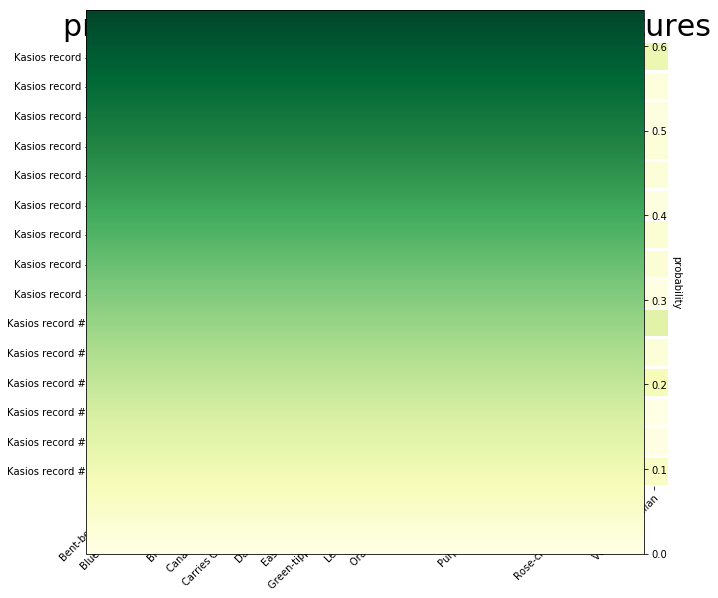

In [87]:
vst.plot_heatmap(probas_kasios,kasios_label, cat_bird.categories.tolist(), 
                 "probability Kasios = specy, 10100 features", 
                 cmap="YlGn", cbarlabel="probability")

<div class="panel panel-primary">
      <div class="panel-heading">Classification and prediction</div>
      <div class="panel-body">
<ul><li>At a first glance, we don't have (except perhaps for K10, K11 and K12) any certitude on the Kasios birds categories.</li>
<li>Lets observe these results with a graph.</li>
</ul></div></div>

<div style="text-align: right"> <a href="#22" class="btn btn-primary">Graph</a></div>

## Visualization on a graph

In [88]:
probas_kasios_labels = []
for k in range(nb_kasios):
    label = ""
    best_probas = heapq.nlargest(5, zip(np.round(probas_kasios[k,:],2), cat_bird.categories.tolist()))
    for i, (proba, catgory) in enumerate(best_probas):
        label += "P" + str(i+1) + ": " + str(proba)+ " - " + catgory + "\n"
    probas_kasios_labels.append(label)

In [89]:
def create_graph2(similarity, probas, threshold1=0.75, threshold_probas=0.1):
    (p, n) = probas.shape
    G = nx.Graph()
    for i in range(n+p):
        G.add_node(i)
    for i in range(n):
        for j in range(i+1, n):
            if (similarity[i,j] > threshold1):
                G.add_edge(i, j, weight= (similarity[i,j] - threshold1) * 100, stype = 0)
    for j in range(p):
        for i in range(n):
            if (probas[j, i] > threshold_probas):
                G.add_edge(n + j, i, weight = 2 * np.sqrt((probas[j, i] - threshold_probas) * 100), stype = 1)
    return G

In [90]:
G2 = create_graph2(ssim_beetween, probas_kasios)

for ix in G2.nodes():
    if ix < nb_categories:
        G2.node[ix]['category'] = cat_bird.categories.tolist()[ix]
        G2.node[ix]['tip'] = cat_bird.categories.tolist()[ix]
        G2.node[ix]['isKasios'] = 0
    else:
        G2.node[ix]['category'] = 'K' + str(ix - nb_categories + 1)
        G2.node[ix]['tip'] = probas_kasios_labels[ix - nb_categories]
        G2.node[ix]['isKasios'] = 1
for ix,deg in G2.degree():
    G2.node[ix]['degree'] = deg
    G2.node[ix]['parity'] = (1-deg%2)
    #G.node[ix]['katz'] = 0.1
for ix,katz in nx.katz_centrality(G2).items():
    G2.node[ix]['katz'] = katz

In [91]:
# create a json file
datajson2 = json_graph.node_link_data(G2)
with open('graphsim2.json', 'w') as f:
    json.dump(datajson2, f, indent=4)

<a id='22'></a>

In [92]:
display(HTML(vst.js_getResults2))

<div class="panel panel-primary">
      <div class="panel-heading">Create features step 1</div>
      <div class="panel-body">
<ul><li>With a threshold of 0.1 for the probabilities, K9, K13, K2, K8 and may be K1 could be Rose-crested Blue Pipits.</li>
<li>Other have only a very small probability to belong to the Blue Pipit specy.</li>
</ul></div></div>

<div style="text-align: right"> <a href="#23" class="btn btn-primary">Comparison of Features</a></div>

In [93]:
list_kasios_bp = [i for i in range(nb_kasios) if probas_kasios[i,16]>0.1]

## Top-3

In [94]:
print("--------------3 MOST PROBABLE SPECIES BY KASIOS RECORD------------------------")
print("******************************************************************************")
for j in range(nb_kasios):
    bestprobas = heapq.nlargest(3, zip(probas_kasios[j,:], cat_bird.categories.tolist()))
    print("Kasios record #", j+1, " : ")
    for i, bestproba in enumerate(bestprobas):
        print("      {} : {} , proba {}".format(i+1, bestproba[1], bestproba[0]))

--------------3 MOST PROBABLE SPECIES BY KASIOS RECORD------------------------
******************************************************************************
Kasios record # 1  : 
      1 : Orange Pine Plover , proba 0.2325603567771147
      2 : Rose-crested Blue Pipit , proba 0.16442669980066366
      3 : Vermillion Trillian , proba 0.10882016278833276
Kasios record # 2  : 
      1 : Rose-crested Blue Pipit , proba 0.1828847858081056
      2 : Ordinary Snape , proba 0.16586969109055938
      3 : Eastern Corn Skeet , proba 0.14791976605304016
Kasios record # 3  : 
      1 : Bombadil , proba 0.16420298016867563
      2 : Orange Pine Plover , proba 0.15570455155746507
      3 : Ordinary Snape , proba 0.09036977364045032
Kasios record # 4  : 
      1 : Bombadil , proba 0.2408088235294117
      2 : Darkwing Sparrow , proba 0.1798713235294117
      3 : Lesser Birchbeere , proba 0.0842830882352941
Kasios record # 5  : 
      1 : Orange Pine Plover , proba 0.2610922436459246
      2 : Blue-co

## Comparison feature / predicted feature

In [95]:
from scipy.stats import mode

In [96]:
predict = random_forest.predict(X_kasios)

i = 0
predict_kasios = []
for j in range(nb_kasios):
    predict_kasios.append(mode(np.array([predict[i+k] for k in range(kasios_id.value_counts()[j])]), axis=None))
    i+=kasios_id.value_counts()[j]
predict_kasios = np.array(predict_kasios).T[0][0].astype(int)

In [97]:
def plot_comparaison_predict(prediction):
    fig, axs = plt.subplots(len(l_kasios_id), 9, figsize=(18,40))
    plt.subplots_adjust(hspace = 0.5)
    for i, H1, H2, H3 in zip(l_kasios_id, features1k, features2k, features3k):
        title_bp = ""
        if i in list_kasios_bp:
            title_bp = ", may be a Blue pipit "
        for j in range(9):
            axs[int(i),j].axis('off')
        vst.plot3_features(cat_bird.categories.tolist()[i_bp], features1[i_bp], 
                           features2[i_bp], features3[i_bp], 
                           freqs, axs[int(i),0:3])    
        vst.plot3_features("K#" + str(int(i + 1)) + title_bp, H1, H2, H3, 
                           freqs, axs[int(i),3:6])
        vst.plot3_features("predicted : K#" + str(int(i + 1)) + "=" +\
                           cat_bird.categories.tolist()[prediction[int(i)]], 
                           features1[prediction[int(i)]], 
                           features2[prediction[int(i)]], 
                           features3[prediction[int(i)]], 
                           freqs, axs[int(i),6:9])

<a id='23'></a>

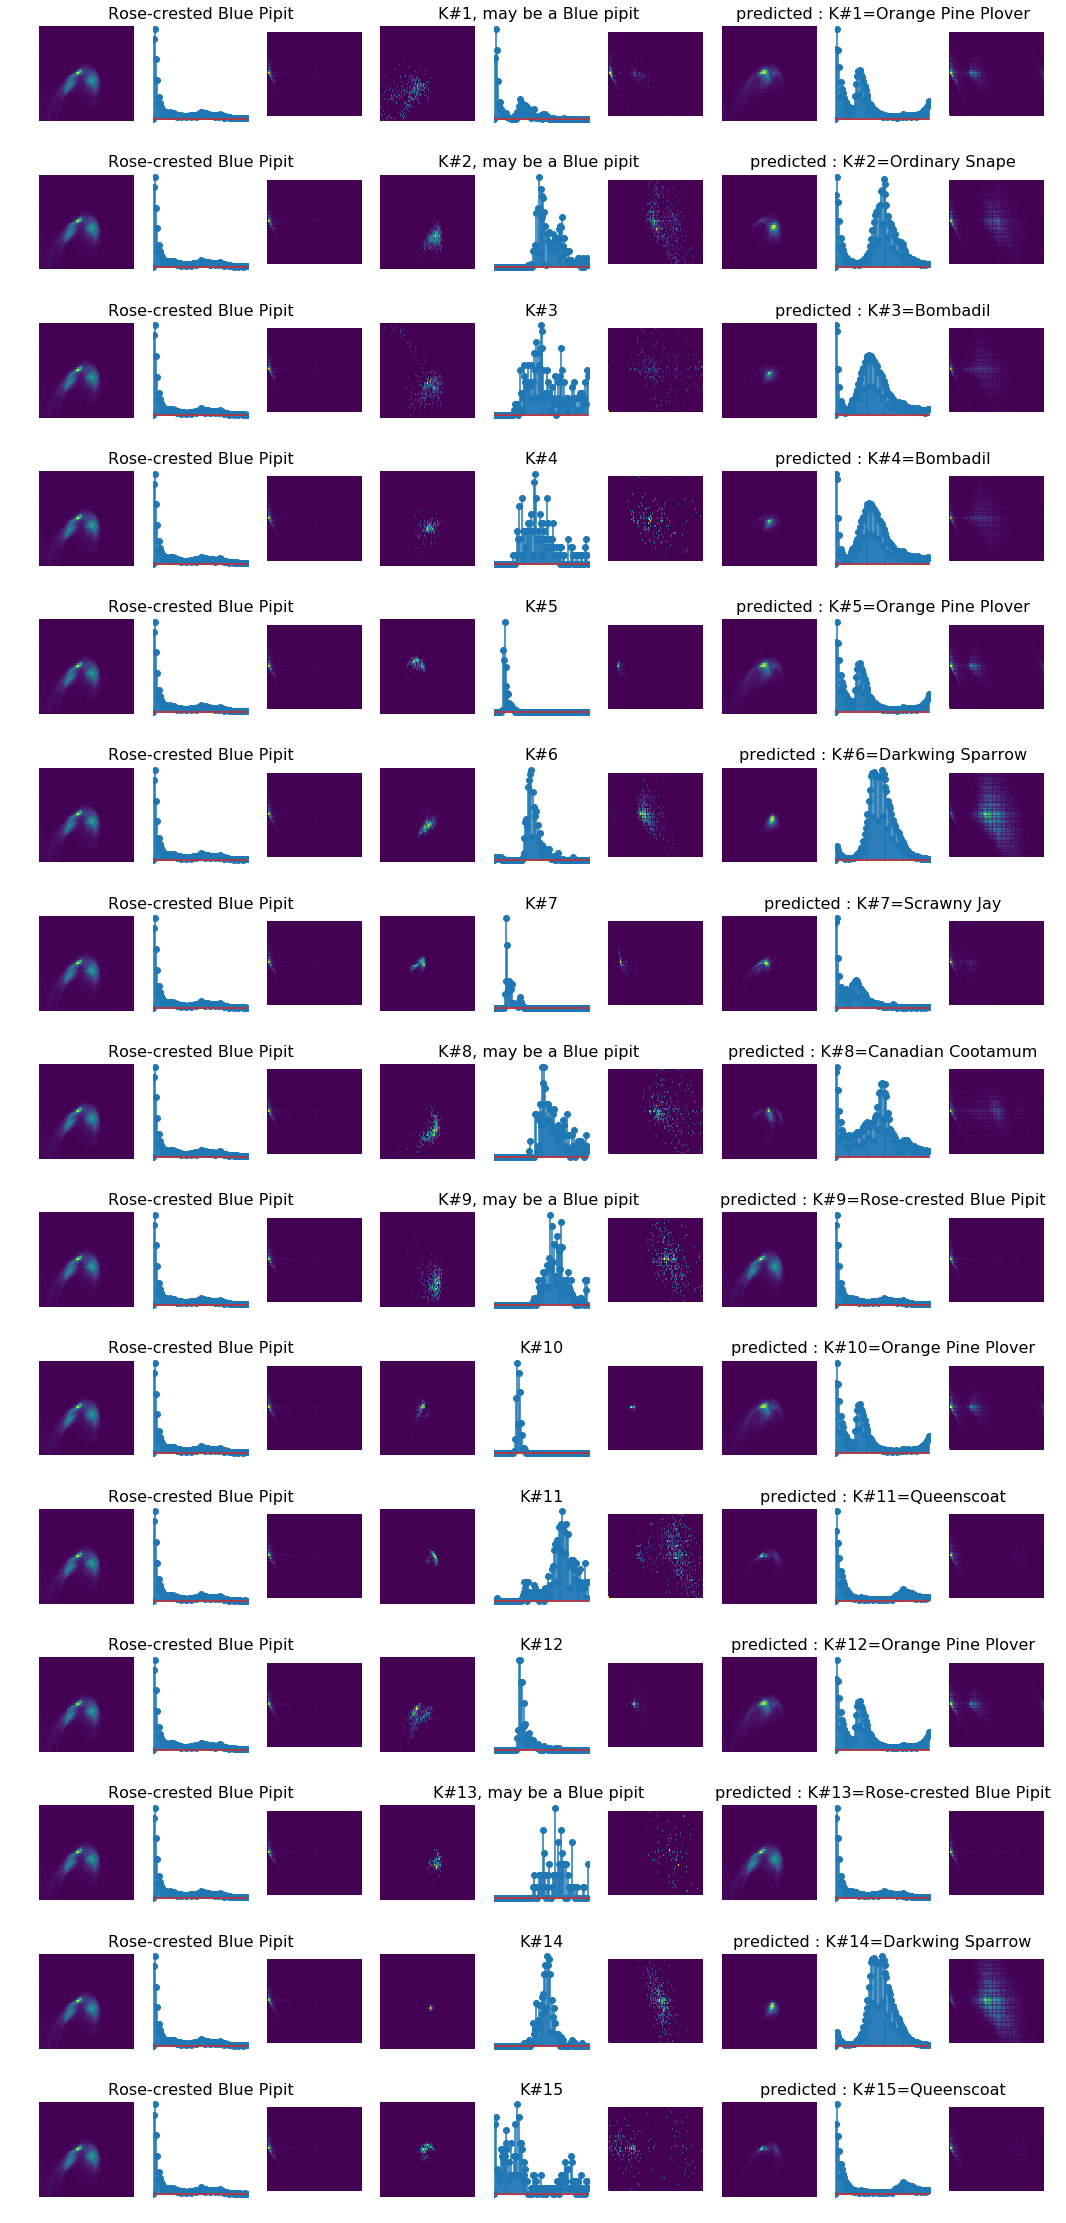

In [98]:
plot_comparaison_predict(predict_kasios)

<div class="panel panel-primary">
      <div class="panel-heading">Features comparison</div>
      <div class="panel-body">
<ul><li>As far we can observe, the prediction is not to bad with these features. </li>
<li> Without classification ML methods, we are unable to predict eyeballed the specy.</li>
</ul></div></div>

<div style="text-align: right"> <a href="#24" class="btn btn-primary">Confirmation with UMAP</a></div>

# Dimensionality Reduction

In [99]:
data_with_kasios = np.concatenate((X,dataset_kasios.groupby(['0']).mean()),axis=0)

## t-SNE

```python
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='random',
                     random_state=0, perplexity=100)
Y = tsne.fit_transform(data_with_kasios)
np.save('resultTSNE.npy', Y) 
```

In [100]:
def plot_red_dim(points, title, labels, show=-1):
    if show == -1:
        colors = ['#a6cee3','#009432','#b2df8a','#33a02c','#fb9a99','#e31a1c',
                  '#e84118','#b15928','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a',
                  '#004d40','#7B1FA2','#7C4DFF','#795548','#0652DD','#B53471',
                  '#FF9800','#8BC34A','#CDDC39','#b71c1c','#FFC107','#607D8B']   
    else:
        colors = ['#0652DD' if i==show else '#009432' for i in range(19)]
    a1 = points[:-15, 0]
    a2 = points[:-15, 1]
    df = pd.DataFrame(dict(a1=a1, a2=a2, label=labels))
    groups = df.groupby('label')
    points_kasios  = points[-15:,:]
    fig, ax = plt.subplots(figsize=(15,15))
    #ax.scatter(points_all_birds[:, 0], points_all_birds[:, 1],marker='.' , color=colors, cmap='tab20', label=labels)
    for i, (name, group) in enumerate(groups):
        ax.scatter(group.a1, group.a2, marker='.', color=colors[i], label=cat_bird.categories.tolist()[name])
    ax.legend(bbox_to_anchor=(1.1, 1.05))
    for i in range(15):
        if show == -1:
            colork = colors[predict_kasios[i]]
        else:
            if i in list_kasios_bp:
                colork='#0652DD'
            else:
                colork = 'orange'
        ax.text(points_kasios[i,0], points_kasios[i, 1], str(i+1), color='black',
                ha="center", va="center", 
                bbox={'pad':0.4, 'boxstyle':'circle',
                      'edgecolor':'none', 'facecolor':colork}) 
    plt.axis('off')
    plt.title(title, fontsize = 20)
    #plt.legend(loc=2, scatterpoints=1)
    plt.show()

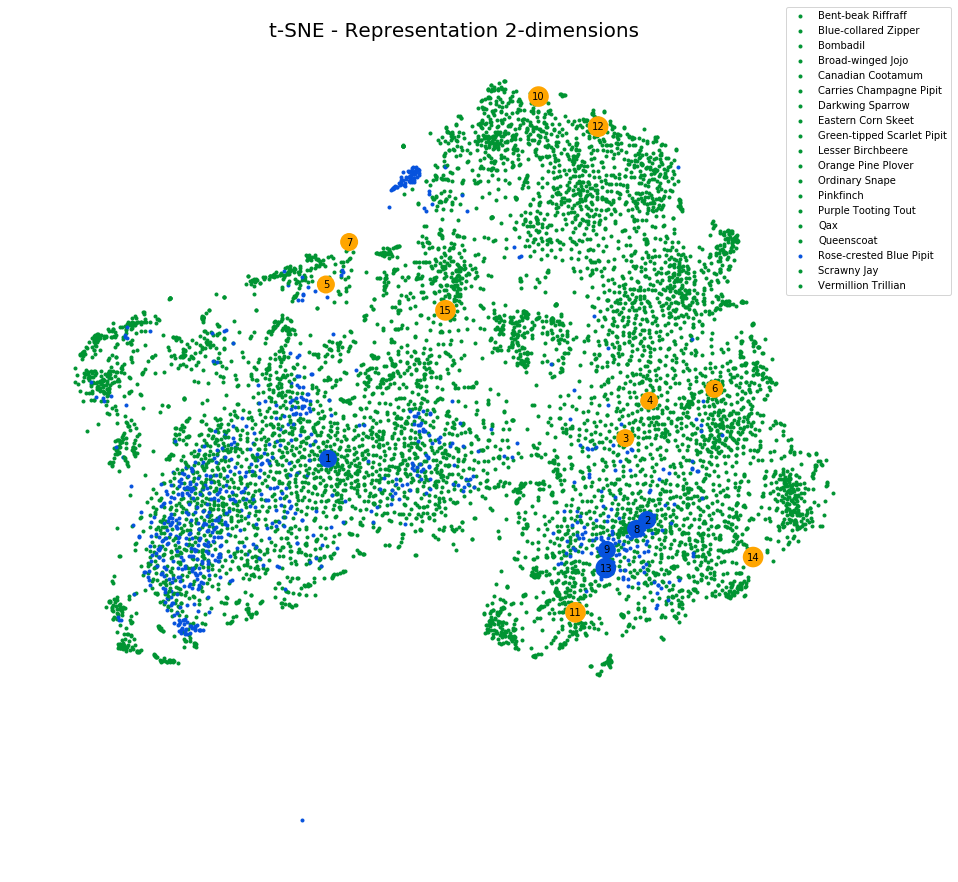

In [101]:
plot_red_dim(np.load('resultTSNE.npy'), 't-SNE - Representation 2-dimensions', y, show=16)

## UMAP


```python
import umap
embedding = umap.UMAP(n_neighbors=25,
                      min_dist=0.3,
                      metric='correlation').fit_transform(data_with_kasios)
np.save('resultUMAP.npy', embedding)
```

<a id='24'></a>

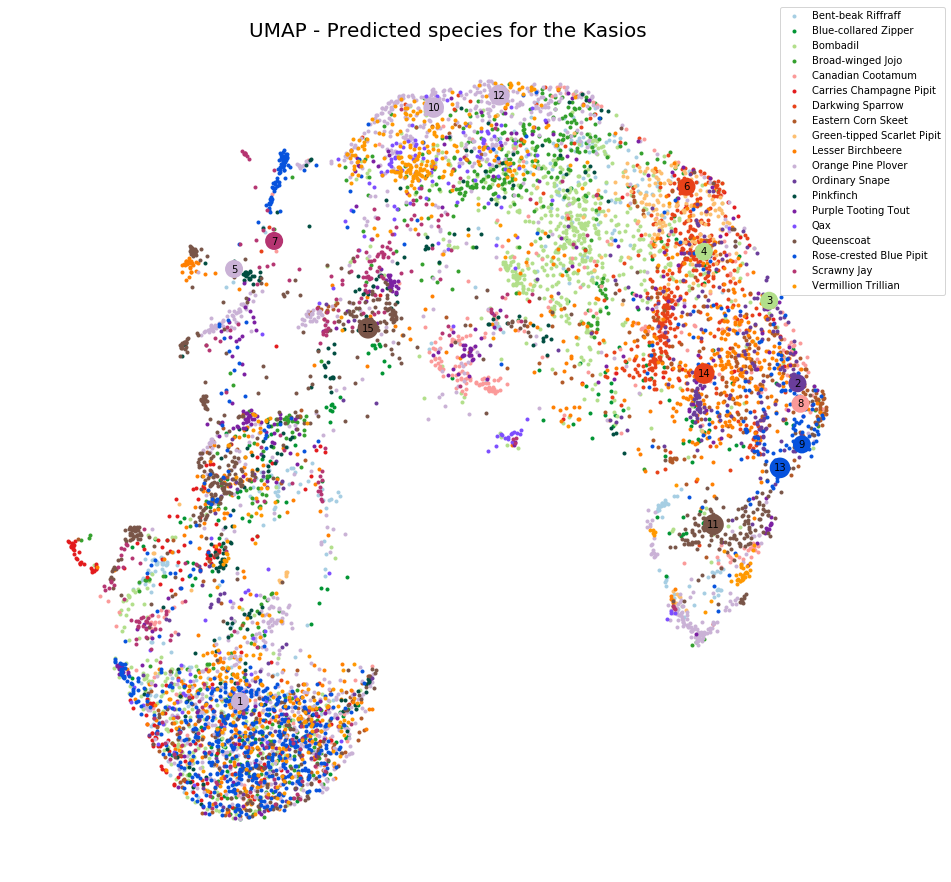

In [102]:
plot_red_dim(np.load('resultUMAP.npy'), 'UMAP - Predicted species for the Kasios', y)

<div class="panel panel-primary">
      <div class="panel-heading">Predicted species</div>
      <div class="panel-body">
<ul><li>As far we can observe, the prediction is consistent. </li>
</ul></div></div>

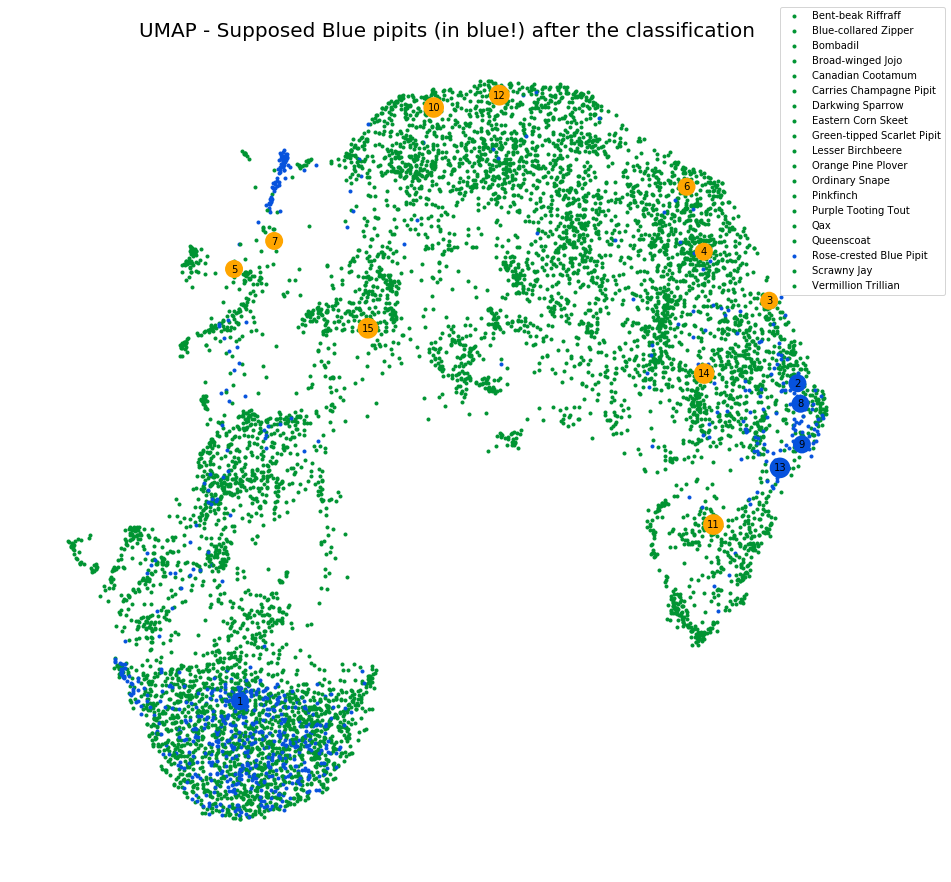

In [103]:
plot_red_dim(np.load('resultUMAP.npy'), 'UMAP - Supposed Blue pipits (in blue!) after the classification', y, show=16)

<div class="panel panel-primary">
      <div class="panel-heading">Features comparison</div>
      <div class="panel-body">
<ul><li>We keep the #2, #9, #8, #13 and  #1 as Blue Pipits </li>
<li> We now have to concluude</li>
</ul></div></div>

<div style="text-align: right"> <a href="#25" class="btn btn-primary">Conclusion</a></div>

<a id='25'></a>

# Conclusion

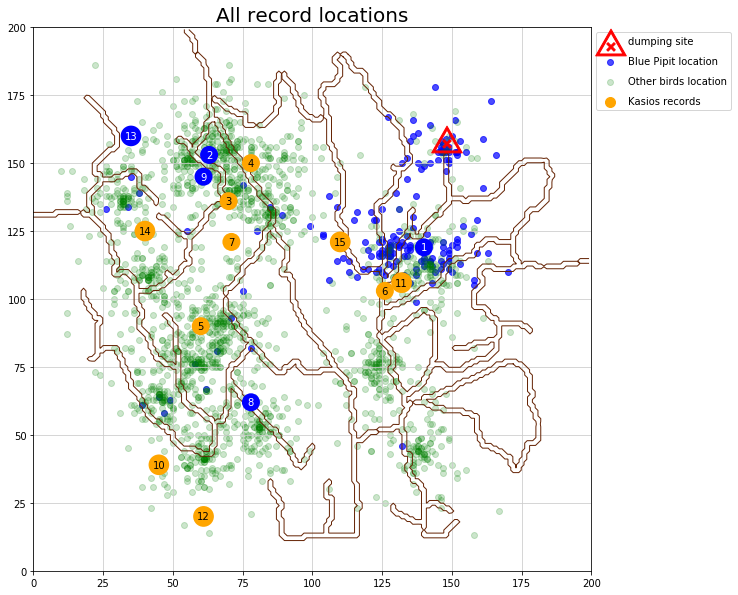

In [104]:
vst.plotmap(data, kasios_records, map_contour, list_kasios_bp)

<div class="panel panel-primary">
      <div class="panel-heading">Conclusion</div>
      <div class="panel-body">
<ul><li>We can assume that #2, #9, #8, #13 are Blue Pipits, and #1 too (even if the most probable specy of #1 is Orange Pine Plower).</li>
<li>But other Kasios records seem to be issued from other species, the sincerity of Kasios has to be challenged. 
</li>
<li>We can't support the report of Kasios: "there are plenty of Rose-crested Blue Pipits happily living and nesting in the Preserve". </li>
<li>We can only conclude that there is still at least a small Blue Pipits population in the Preserve, which mainly probably not nest in the dumping area.</li>
<li>We indeed observed that the number of Blue pipits recorded in the vicinity of this dumping site decreased in recent years.
</li>
<li>Machine learning is powerful, but the human Mitch Vogel's experience is essential.</li>
</ul></div></div>